In [33]:
import pandas as pd
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import spearmanr
import scanpy as sc
from functools import reduce

import os
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.preprocessing import StandardScaler


# Cell Type GO Terms are Enriched for Brain Gene Markers

First, load GO terms that are curated for their cell type relatedness

In [34]:
GO_curations = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv", sep = "\t")
GO_curations.head()

def create_new_column(df):
    """
    Create a new column based on conditions in existing columns.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - pandas DataFrame with a new column "NewColumn"
    """
    # Create a new column using conditions
    meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)

    return meta

GO_curations['meta'] = create_new_column(GO_curations)

Next, load the GO annotations, which shows what genes are affiliated with which GO terms

In [35]:
GO_annots = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/processing/bp_annotations_withGeneData_qc_annotations.csv")
GO_annots.head()

,DB_Object_Symbol,GO ID,Aspect,DB Object Name,ensembl_gene_id,hgnc_symbol,uniprotswissprot,entrezgene_id,description
0,IRGM,GO:0000045,P,Immunity-related GTPase family M protein,ENSG00000237693,IRGM,A1A4Y4,345611.0,immunity related GTPase M [Source:HGNC Symbol;...
1,BECN2,GO:0000045,P,Beclin-2,ENSG00000196289,BECN2,A8MW95,441925.0,beclin 2 [Source:HGNC Symbol;Acc:HGNC:38606]
2,AP4M1,GO:0000045,P,AP-4 complex subunit mu-1,ENSG00000221838,AP4M1,NaN,9179.0,adaptor related protein complex 4 subunit mu 1...
3,ATG13,GO:0000045,P,Autophagy-related protein 13,ENSG00000175224,ATG13,NaN,9776.0,autophagy related 13 [Source:HGNC Symbol;Acc:H...
4,ULK1,GO:0000045,P,Serine/threonine-protein kinase ULK1,ENSG00000177169,ULK1,O75385,8408.0,unc-51 like autophagy activating kinase 1 [Sou...


Next, load our cell type markers for brain and PBMC cells

In [36]:
brain_markers = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/bin/notebooks/brain_markers.csv"
# pbmc_markers = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/data/dev/july_27/markers/pbmc_sc_with_metadata_pc_cpm_markers.csv"
random_markers = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/bin/notebooks/brain_random_markers.csv"
brain_markers = pd.read_csv(brain_markers)
# pbmc_markers = pd.read_csv(pbmc_markers)
random_markers = pd.read_csv(random_markers)

brain_markers.sort_values('group').head()


,group,names,scores,logfoldchanges,pvals,pvals_adj,ensembl_gene_id
0,Astrocytes,GPC5,40.2000,9.75,0.000000e+00,0.000000e+00,ENSG00000179399
520,Astrocytes,ATP13A5,5.8000,3.83,6.460000e-09,1.410000e-08,ENSG00000187527
904,Astrocytes,CCIN,0.0617,3.43,9.510000e-01,9.990000e-01,ENSG00000185972
522,Astrocytes,HES5,5.7300,4.56,1.020000e-08,2.220000e-08,ENSG00000197921
523,Astrocytes,FBLN1,5.7000,4.76,1.180000e-08,2.560000e-08,ENSG00000077942


Now, perform fisher exact tests that test the enrichment of brain markers in brain GO terms, and the enrichment of PBMC markers in PBMC GO terms

In [37]:
def count_overlaps(id:str, GO_annots:pd.DataFrame, df_marker_genes:pd.DataFrame) -> tuple:
    """Counts the overlap between a GO term's genes and a list of marker genes

    Args:
        id (str): a GO ID
        GO_annots (pd.DataFrame): Annotation dataframe that gives what genes are affiliated with this GO term
        df_marker_genes (pd.DataFrame): dfof marker genes to calculate enrichment of

    Returns:
        tuple: tuple containing the GO ID, the number of marker genes it has, and the number of non-marker genes it has
    """
    # For each id, filter the annotation df for this GO id
    filtered_go_annots = GO_annots[GO_annots.loc[:,'GO ID'] == id]
    # get all of the genes in this go id
    lo_genes_in_id = filtered_go_annots.hgnc_symbol
    # Count how many of these genes are cell type marker genes and how many are not
    lo_bools = list(lo_genes_in_id.isin(df_marker_genes.names))
    count_true = lo_bools.count(True)
    count_false = lo_bools.count(False)
    return id, count_true, count_false

def calculate_enrichment_for_tissue(ser_ct_related_terms:pd.Series, df_marker_genes:list) -> pd.DataFrame:
    """Calculates the enrichment of a series of cell type related GO Terms across a list of marker genes

    Args:
        ser_ct_related_terms (pd.Series): The GO terms to calculate enrichment for
        df_marker_genes (pd.DataFrame): Df marker genes to calculate enrichment for

    Returns:
        pd.DataFrame: Dataframe detailing how many marker genes each GO term has
    """
    lo_enrichments = []
    for id in ser_ct_related_terms:
        tuple_enrichments = count_overlaps(id, GO_annots=GO_annots,  df_marker_genes=df_marker_genes)
        lo_enrichments.append(tuple_enrichments)
    df = pd.DataFrame(lo_enrichments, columns = ['id', 'n_marker_genes', 'n_other_genes'])
    df['fraction'] = df.loc[:,'n_marker_genes'] / (df.loc[:,'n_marker_genes'] + df.loc[:,'n_other_genes'])
    return df

def calc_enrichment_for_markers(GO_curations, df_marker_genes):
    ser_brain_related_terms = GO_curations[GO_curations.loc[:,'BrainAffiliated']=="T"].id
    ser_pbmc_related_terms = GO_curations[GO_curations.loc[:,'PBMCAffiliated']=="T"].id
    ser_neither_related_terms = GO_curations[(GO_curations.loc[:,'BrainAffiliated']!="T") & (GO_curations.loc[:,'PBMCAffiliated']!="T") ].id
    
    brain_enrichment = calculate_enrichment_for_tissue(ser_ct_related_terms=ser_brain_related_terms, df_marker_genes= df_marker_genes)
    pbmc_enrichment = calculate_enrichment_for_tissue(ser_ct_related_terms=ser_pbmc_related_terms, df_marker_genes= df_marker_genes)
    neither_enrichment = calculate_enrichment_for_tissue(ser_ct_related_terms=ser_neither_related_terms, df_marker_genes= df_marker_genes)
    
    brain_enrichment['enrichment'] = 'brain'
    pbmc_enrichment['enrichment'] = 'pbmc'
    neither_enrichment['enrichment'] = 'neither'
    
    return pd.concat([brain_enrichment, pbmc_enrichment, neither_enrichment], axis = 0)

def calc_enrichment_for_tissues(GO_curations:pd.DataFrame, brain_markers:pd.DataFrame, random_markers:pd.DataFrame) -> tuple:
    """Calculate the enrichment of Brain Markers and Random Markers in brain tissue for Differently curated Cell type affiliated GO terms

    Args:
        GO_curations (pd.DataFrame): Curations of what GO terms is affiliated to each tissue
        brain_markers (pd.DataFrame): df of marker genes for brain
        random_markers (pd.DataFrame): df of random genes

    Returns:
        merged : df containing enrichment in brain for marker genes and random genes, across different "types" of GO terms
    """

    enrichment_brain_markers = calc_enrichment_for_markers(GO_curations=GO_curations, df_marker_genes=brain_markers) # Enrichment of Brain Markers
    enrichment_random_markers = calc_enrichment_for_markers(GO_curations=GO_curations, df_marker_genes=random_markers) # Enrichment of Random Markers
    
    # Add metadata
    enrichment_brain_markers['marker_type']='Brain'
    enrichment_random_markers['marker_type']='Random'
    
    # conct
    merged = pd.concat([enrichment_brain_markers, enrichment_random_markers], axis = 0)
    
    return merged

# Here, we get a dataframe containing our enrichments
enrichment_master = calc_enrichment_for_tissues(GO_curations=GO_curations,
                                                brain_markers=brain_markers,
                                                random_markers=random_markers)
enrichment_master.to_csv("data/GO_term_enrichment_master.csv")

### Perform Statistical Analysis To Quantify Enrichment

In [38]:
# Create a formula for the ANOVA model
formula = 'fraction ~ C(enrichment) + C(marker_type) + C(enrichment):C(marker_type)'

enrichment_master['enrichment'] = pd.Categorical(enrichment_master['enrichment'], categories=['neither', 'brain', 'pbmc'], ordered=True)
enrichment_master['marker_type'] = pd.Categorical(enrichment_master['marker_type'], categories=['Random', 'Brain'], ordered=True)

# Fit the ANOVA model
model = ols(formula, data=enrichment_master, ).fit()

# Print the ANOVA table
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fraction   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     45.99
Date:                Mon, 02 Sep 2024   Prob (F-statistic):           8.71e-46
Time:                        11:07:11   Log-Likelihood:                 2734.6
No. Observations:                2792   AIC:                            -5457.
Df Residuals:                    2786   BIC:                            -5422.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.1692      0.003     63.568      0.000       0.164       0.174
C(enrichment)[T.brain]                            -0.0180      0.009     -1.921      0.055      -0.036       0.000
C(enrichment)[T.pbmc]                             -0.0357      0.009     -4.188      0.000      -0.052      -0.019
C(marker_type)[T.Brain]                            0.0146      0.004      3.884      0.000       0.007       0.022
C(enrichment)[T.brain]:C(marker_type)[T.Brain]     0.0766      0.013      5.768      0.000       0.051       0.103
C(enrichment)[T.pbmc]:C(marker_type)[T.Brain]      0.1208      0.012     10.012      0.000       0.097       0.144
==============================================================================
Omnibus:                       44.926   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.053
Skew:                           0.286   Prob(JB):                     3.68e-11
Kurtosis:                       3.292   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
model.pvalues

Intercept                                         0.000000e+00
C(enrichment)[T.brain]                            5.478880e-02
C(enrichment)[T.pbmc]                             2.899008e-05
C(marker_type)[T.Brain]                           1.052157e-04
C(enrichment)[T.brain]:C(marker_type)[T.Brain]    8.884659e-09
C(enrichment)[T.pbmc]:C(marker_type)[T.Brain]     3.315914e-23
dtype: float64

In [40]:
# Tukey
enrichment_master['interaction']=enrichment_master['enrichment'].str.cat(enrichment_master['marker_type'], sep=":")

def perform_tukey(df, y_col):
    tukey = pairwise_tukeyhsd(df[y_col], groups = df['interaction'])
    
    pvalues = tukey.pvalues
    
    tukey_df = pd.DataFrame(tukey.summary())
    
    tukey_df.columns = tukey_df.iloc[0,:]
    tukey_df = tukey_df.drop(tukey_df.index[0])
    return tukey_df, pvalues
enrichment_master_tukey, pvals = perform_tukey(df = enrichment_master, y_col = 'fraction')
print(enrichment_master_tukey)
# Set pandas display options to show more significant figures
print(pvals)

0           group1          group2 meandiff   p-adj    lower    upper reject
1      brain:Brain    brain:Random  -0.0912     0.0  -0.1276  -0.0549   True
2      brain:Brain   neither:Brain  -0.0586     0.0  -0.0854  -0.0318   True
3      brain:Brain  neither:Random  -0.0732     0.0     -0.1  -0.0464   True
4      brain:Brain      pbmc:Brain   0.0265  0.2449  -0.0081    0.061  False
5      brain:Brain     pbmc:Random  -0.1089     0.0  -0.1435  -0.0744   True
6     brain:Random   neither:Brain   0.0327  0.0068   0.0059   0.0594   True
7     brain:Random  neither:Random    0.018  0.3891  -0.0087   0.0448  False
8     brain:Random      pbmc:Brain   0.1177     0.0   0.0832   0.1523   True
9     brain:Random     pbmc:Random  -0.0177  0.6904  -0.0522   0.0169  False
10   neither:Brain  neither:Random  -0.0146  0.0015  -0.0254  -0.0039   True
11   neither:Brain      pbmc:Brain    0.085     0.0   0.0607   0.1094   True
12   neither:Brain     pbmc:Random  -0.0503     0.0  -0.0747   -0.026   True

In [41]:
def get_enrichment_fc(enrichment_master=enrichment_master):
    grouped =     enrichment_master.groupby(['enrichment', 'marker_type'])['fraction'].median().reset_index()
    marker_brain = grouped[grouped.loc[:,'marker_type']=="Brain"]
    brain_enrichment_fc = marker_brain[marker_brain.loc[:,'enrichment']=='brain'].loc[:,'fraction'].values[0] / marker_brain[marker_brain.loc[:,'enrichment']=='neither'].loc[:,'fraction'].values[0]
    pbmc_enrichment_fc = marker_brain[marker_brain.loc[:,'enrichment']=='pbmc'].loc[:,'fraction'].values[0] / marker_brain[marker_brain.loc[:,'enrichment']=='neither'].loc[:,'fraction'].values[0]
    return brain_enrichment_fc, pbmc_enrichment_fc
def get_neither_enrichment_fc(enrichment_master=enrichment_master):
    grouped =   enrichment_master.groupby(['enrichment', 'marker_type'])['fraction'].median().reset_index()
    marker_brain = grouped[grouped.loc[:,'enrichment']=="neither"]
    neither_enrichment_fc = marker_brain[marker_brain.loc[:,'marker_type']=='Brain'].loc[:,'fraction'].values[0] / marker_brain[marker_brain.loc[:,'marker_type']=='Random'].loc[:,'fraction'].values[0]
    return neither_enrichment_fc
neither_enrichment_fc = get_neither_enrichment_fc(enrichment_master=enrichment_master)
print(neither_enrichment_fc)
brain_enrichment_fc, pbmc_enrichment_fc = get_enrichment_fc()
print(brain_enrichment_fc)
# print(pbmc_enrichment_fc)

1.1111111111111112
1.2283685064935066


/tmp/ipykernel_1964898/3601585246.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped =   enrichment_master.groupby(['enrichment', 'marker_type'])['fraction'].median().reset_index()
/tmp/ipykernel_1964898/3601585246.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped =     enrichment_master.groupby(['enrichment', 'marker_type'])['fraction'].median().reset_index()


In [42]:
enrichment_master

,id,n_marker_genes,n_other_genes,fraction,enrichment,marker_type,interaction
0,GO:0001764,29,77,0.273585,brain,Brain,brain:Brain
1,GO:0002052,10,19,0.344828,brain,Brain,brain:Brain
2,GO:0006836,7,30,0.189189,brain,Brain,brain:Brain
3,GO:0007214,4,24,0.142857,brain,Brain,brain:Brain
4,GO:0007268,51,173,0.227679,brain,Brain,brain:Brain
...,...,...,...,...,...,...,...
1163,GO:2001237,4,33,0.108108,neither,Random,neither:Random
1164,GO:2001238,3,24,0.111111,neither,Random,neither:Random
1165,GO:2001240,5,29,0.147059,neither,Random,neither:Random
1166,GO:2001243,4,19,0.173913,neither,Random,neither:Random


Graph the enrichment of markers in brain tissue

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_1964898/2641622800.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), fontsize = 16)  # Adjust x-axis tick labels


<Figure size 640x480 with 0 Axes>

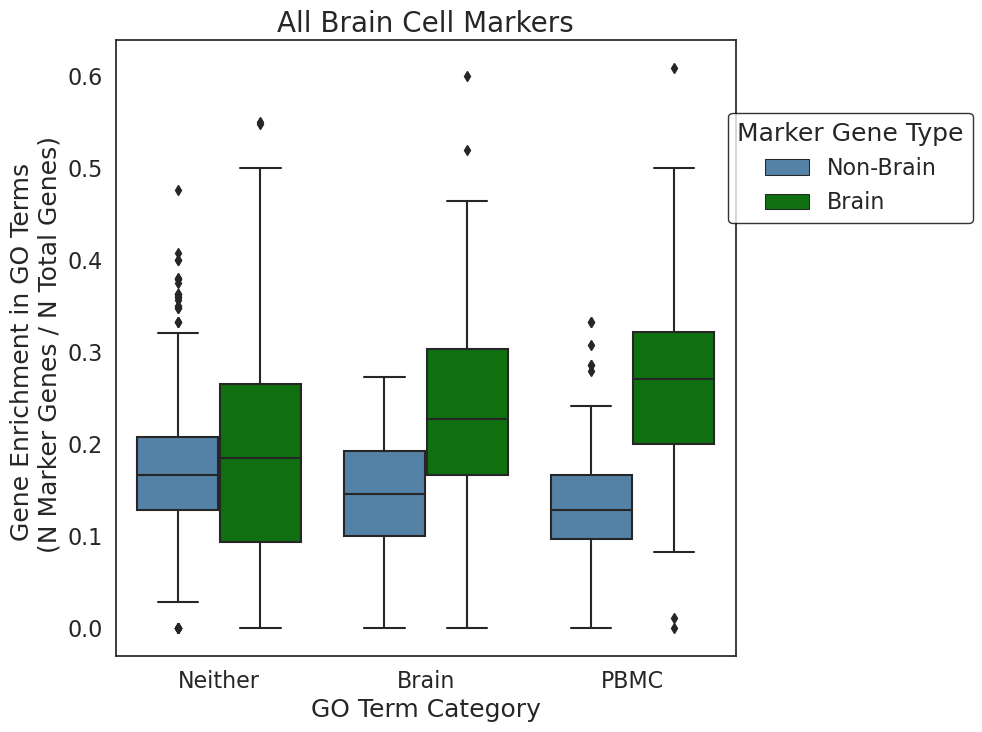

In [43]:
def plot_enrichment(enrichment_master, title:str):
    sns.set(style="white", font_scale=1.2)# Set up plot parameters

    plt.figure(figsize=(8, 8))  # Adjust figure size

    # Define custom colors for 'Brain' and 'Random'
    custom_palette = ["steelblue", "green"]
    enrichment_master['marker_type'] = enrichment_master['marker_type'].replace({"Random":"Non-Brain", 
                                                                                 "Brain":"Brain"})
    # Create the violin plot
    g = sns.boxplot(data=enrichment_master, x='enrichment', y='fraction', hue='marker_type', palette = custom_palette)

    # g.set_ybound(lower=0, upper=1)
    # Add titles and labels
    plt.title(title, fontsize=20)
    plt.xlabel("GO Term Category", fontsize=18)
    plt.ylabel("Gene Enrichment in GO Terms \n (N Marker Genes / N Total Genes)", fontsize=18)
    

    # Modify legend title
    g.legend(title = "Marker Gene Type", edgecolor='black', fancybox=True, fontsize=16, title_fontsize = 18, bbox_to_anchor=(1.4, 0.9))
    # g.get_legend().set_title("Gene Type", prop={'size': 18})
    # g._legend_title_box._text.set_color('#FFFFFF')
    # g.get_legend().set_bbox_to_anchor((1.0, 0.9))
    

    # Change x-axis tick names
    g.set_xticklabels(["Neither", "Brain", "PBMC"], fontsize = 16)  # Adjust x-axis tick labels
    g.set_yticklabels(g.get_yticklabels(), fontsize = 16)  # Adjust x-axis tick labels


    # Saveplot
    plt.savefig(f"final/{title.replace(' ', '_')}_CT_marker_enrichment.png", dpi = 300, bbox_inches='tight')
    # Show the plot
    plt.show()
plt.clf()
# plt.cla()
plot_enrichment(enrichment_master=enrichment_master, title = "All Brain Cell Markers")

# Microglia Genes are Responsible for PBMC Enrichment

In [44]:
brain_markers = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/bin/notebooks/brain_markers.csv"
# pbmc_markers = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/data/dev/july_27/markers/pbmc_sc_with_metadata_pc_cpm_markers.csv"
random_markers = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/bin/notebooks/brain_random_markers.csv"
brain_markers = pd.read_csv(brain_markers)
# pbmc_markers = pd.read_csv(pbmc_markers)
random_markers = pd.read_csv(random_markers)

# Remove microglial marker genes before calculating enrichment
brain_markers = brain_markers[brain_markers.loc[:,'group']!="Microglial cells"]
random_markers = random_markers[random_markers.loc[:,'group']!="Microglial cells"]

# Here, we get a dataframe containing our enrichments
enrichment_master = calc_enrichment_for_tissues(GO_curations=GO_curations,
                                                brain_markers=brain_markers,
                                                random_markers=random_markers)


In [45]:
# # Create a formula for the ANOVA model
formula = 'fraction ~ C(enrichment) + C(marker_type) + C(enrichment):C(marker_type)'

enrichment_master['enrichment'] = pd.Categorical(enrichment_master['enrichment'], categories=['neither', 'brain', 'pbmc'], ordered=True)
enrichment_master['marker_type'] = pd.Categorical(enrichment_master['marker_type'], categories=['Random', 'Brain'], ordered=True)

# Fit the ANOVA model
model = ols(formula, data=enrichment_master, ).fit()

# Print the ANOVA table
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fraction   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     34.93
Date:                Mon, 02 Sep 2024   Prob (F-statistic):           9.36e-35
Time:                        11:07:22   Log-Likelihood:                 3299.2
No. Observations:                2792   AIC:                            -6586.
Df Residuals:                    2786   BIC:                            -6551.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.1282      0.002     58.966      0.000       0.124       0.132
C(enrichment)[T.brain]                            -0.0082      0.008     -1.072      0.284      -0.023       0.007
C(enrichment)[T.pbmc]                             -0.0300      0.007     -4.312      0.000      -0.044      -0.016
C(marker_type)[T.Brain]                            0.0128      0.003      4.153      0.000       0.007       0.019
C(enrichment)[T.brain]:C(marker_type)[T.Brain]     0.0831      0.011      7.658      0.000       0.062       0.104
C(enrichment)[T.pbmc]:C(marker_type)[T.Brain]      0.0160      0.010      1.623      0.105      -0.003       0.035
==============================================================================
Omnibus:                       99.444   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.405
Skew:                           0.426   Prob(JB):                     5.28e-26
Kurtosis:                       3.524   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
print(model.pvalues)

Intercept                                         0.000000e+00
C(enrichment)[T.brain]                            2.837691e-01
C(enrichment)[T.pbmc]                             1.676544e-05
C(marker_type)[T.Brain]                           3.377239e-05
C(enrichment)[T.brain]:C(marker_type)[T.Brain]    2.590287e-14
C(enrichment)[T.pbmc]:C(marker_type)[T.Brain]     1.048068e-01
dtype: float64


In [47]:
# Tukey
enrichment_master['interaction']=enrichment_master['enrichment'].str.cat(enrichment_master['marker_type'], sep=":")

enrichment_master_tukey, pvalues = perform_tukey(df = enrichment_master, y_col = 'fraction')


In [48]:
enrichment_master_tukey

,group1,group2,meandiff,p-adj,lower,upper,reject
1,brain:Brain,brain:Random,-0.0959,0.0,-0.1255,-0.0662,True
2,brain:Brain,neither:Brain,-0.0749,0.0,-0.0967,-0.053,True
3,brain:Brain,neither:Random,-0.0876,0.0,-0.1095,-0.0658,True
4,brain:Brain,pbmc:Brain,-0.0889,0.0,-0.1171,-0.0607,True
5,brain:Brain,pbmc:Random,-0.1177,0.0,-0.1459,-0.0895,True
6,brain:Random,neither:Brain,0.021,0.0685,-0.0009,0.0429,False
7,brain:Random,neither:Random,0.0082,0.8925,-0.0137,0.0301,False
8,brain:Random,pbmc:Brain,0.0069,0.9818,-0.0213,0.0352,False
9,brain:Random,pbmc:Random,-0.0218,0.2359,-0.05,0.0064,False
10,neither:Brain,neither:Random,-0.0128,0.0005,-0.0215,-0.004,True


In [49]:
pvalues

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.85355473e-02, 8.92530332e-01, 9.81822823e-01,
       2.35901196e-01, 4.83182392e-04, 3.32694455e-01, 1.37338757e-08,
       9.99970753e-01, 2.42339632e-04, 2.61318228e-02])

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_1964898/2641622800.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), fontsize = 16)  # Adjust x-axis tick labels


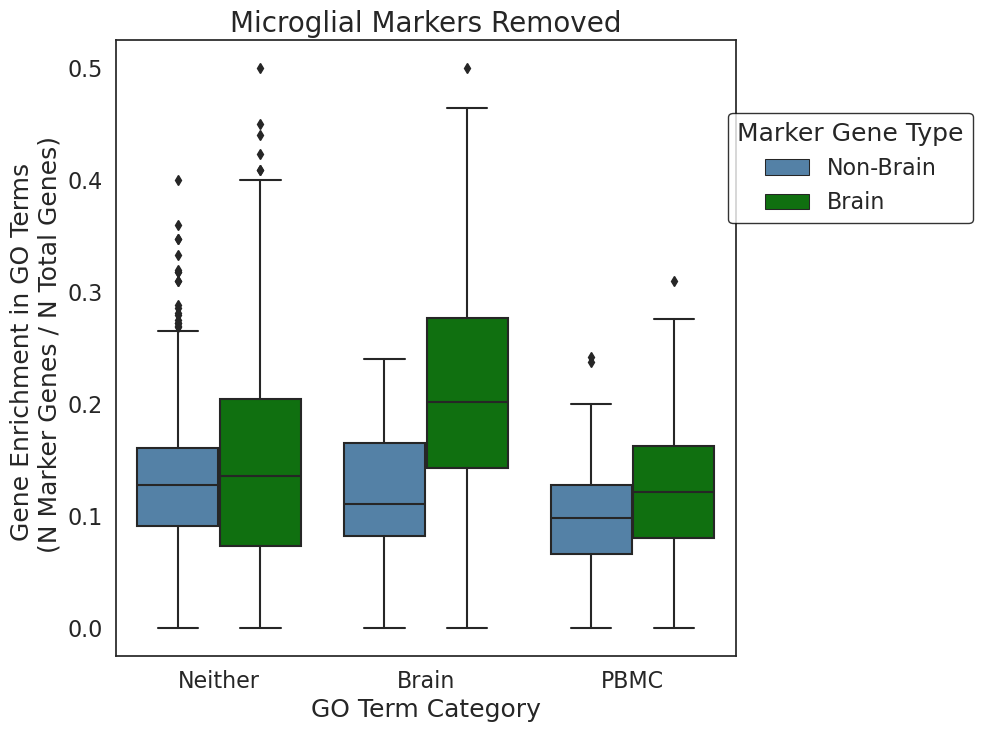

In [50]:
plot_enrichment(enrichment_master=enrichment_master, title = "Microglial Markers Removed")

# Composition Variance Preferrentially increases Performance for CT Related GO Terms

In [51]:
path_to_bootstrap_merged_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bulkSimulationOneProfile/data/boot_run_feb29/master_melted_df.csv.gz"
melted_results = pd.read_csv(path_to_bootstrap_merged_file,index_col=0)

In [52]:
melted_results['exp_type'] = melted_results.organism_part.str.split("_").str.get(0)
melted_results['tissue'] = melted_results.organism_part.str.split("_").str.get(1)

In [53]:
# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")

In [54]:
def create_new_column(df):
    """
    Create a new column based on conditions in existing columns.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - pandas DataFrame with a new column "NewColumn"
    """
    # Create a new column using conditions
    meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)

    return meta

curated_gos['meta'] = create_new_column(curated_gos)

In [55]:
curated_gos = curated_gos.loc[:,['id', 'meta']]

In [56]:
results = melted_results.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()

In [57]:
merged = melted_results.merge(curated_gos, left_on='index', right_on='id')

In [58]:
# Remove no variance
merged = merged[merged.loc[:,'variance']!=0]
# Save this for convenience
# merged.to_csv("data/GO_performances_filtered.csv")
merged.head()


,index,organism_part,bootstrap,variance,auc,exp_type,tissue,id,meta
1,GO:0000045,cntrl_brain_sc_with_metadata_pc_cpm_cell_type_...,3,0.05,0.522443,cntrl,brain,GO:0000045,Neither
3,GO:0000045,exp_brain_sc_with_metadata_pc_cpm_cell_type_pr...,3,0.05,0.537387,exp,brain,GO:0000045,Neither
5,GO:0000045,exp_pbmc_sc_with_metadata_pc_cpm_cell_type_pro...,1,0.05,0.562481,exp,pbmc,GO:0000045,Neither
7,GO:0000045,exp_pbmc_sc_with_metadata_pc_cpm_cell_type_pro...,2,0.05,0.589985,exp,pbmc,GO:0000045,Neither
9,GO:0000045,cntrl_pbmc_sc_with_metadata_pc_cpm_cell_type_p...,5,0.05,0.503032,cntrl,pbmc,GO:0000045,Neither


### Graph

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to T

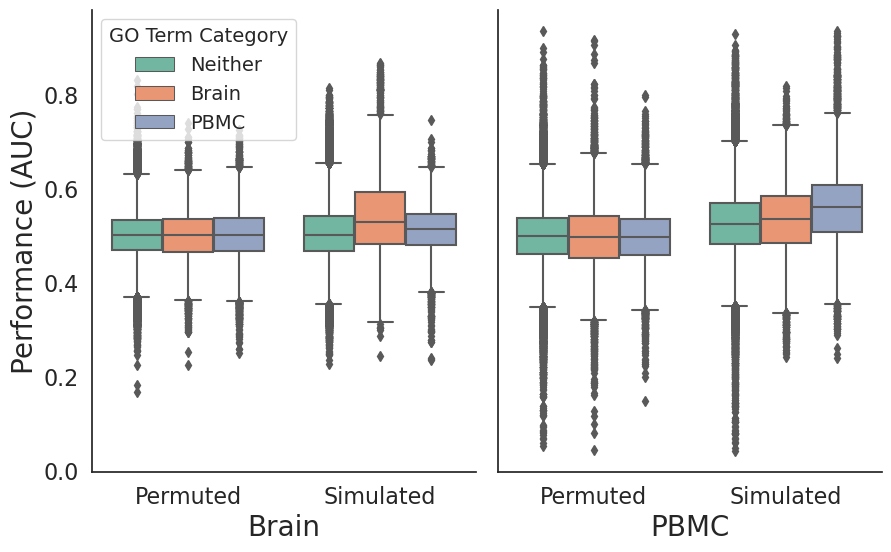

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
# sns.set_palette('Set2')  # Set the color palette to Dark

merged['exp_type'] = pd.Categorical(merged.loc[:,'exp_type'], categories=['cntrl', 'exp'], ordered=True)
merged['meta'] = pd.Categorical(merged.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)

# Create a FacetGrid with seaborn
g = sns.FacetGrid(merged, col="tissue", height=6, aspect=0.75)

# Draw a boxplot in each facet
g.map(sns.boxplot, 'exp_type', 'auc', 'meta', palette="Set2")

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove facet titles
g.set_titles("")

# Set x-axis labels with smaller font size separately for each column
g.axes[0, 0].set_xlabel('Brain', fontsize=20)
g.axes[0, 1].set_xlabel('PBMC', fontsize=20)

# Set y-axis label with smaller font size
g.set_ylabels("Performance (AUC)", fontsize=20)

# Add a legend with a custom title and font size
legend = plt.legend(title="GO Term Category", fontsize=14, bbox_to_anchor=(-0.5,1))

# Set the font size of the legend title
legend.get_title().set_fontsize(14)

# Rename the legend labels
legend.get_texts()[0].set_text("Neither")
legend.get_texts()[1].set_text("Brain")
legend.get_texts()[2].set_text("PBMC")

# Access each axis and set custom tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(["Permuted", "Simulated"], fontsize=16)
    ax.tick_params(axis='y', labelsize=16) 
# Adjust the layout to make room for the title
g.fig.subplots_adjust(top=0.9)

# Add a title to the entire plot
# g.fig.suptitle('Simulated Bulk from Cell Type Profiles', fontsize=16)
# Add a title to the entire plot
# g.fig.suptitle('       Composition Variance Increases \n       Performance of Cell Type Related GO Terms', fontsize=20,  y=1.025)


# Save the plot
g.savefig('final/CTProfileBulkResults.png', dpi = 300)


### Statistics

I will be making a linear model for each Tissue. This was a deliberate decision because I am not really interested in modeling differences across tissues. I am more interested in adressing term performance changes within tissues.

In [60]:
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [61]:
def fit_mixed_model(tissue_df):
    model = smf.mixedlm("auc~exp_type*meta", data = tissue_df, groups = tissue_df['index'], re_formula="~exp_type")
    
    return model.fit()

pbmc = merged[merged['tissue']=="pbmc"]
pbmc['exp_type'] = pd.Categorical(pbmc.loc[:,'exp_type'], categories=['cntrl', 'exp'], ordered=True)
pbmc['meta'] = pd.Categorical(pbmc.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)

brain = merged[merged['tissue']=="brain"]
brain['exp_type'] = pd.Categorical(brain.loc[:,'exp_type'], categories=['cntrl', 'exp'], ordered=True)
brain['meta'] = pd.Categorical(brain.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)

pbmc_model = fit_mixed_model(pbmc)
brain_model = fit_mixed_model(brain)

/tmp/ipykernel_1964898/4253457738.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc['exp_type'] = pd.Categorical(pbmc.loc[:,'exp_type'], categories=['cntrl', 'exp'], ordered=True)
/tmp/ipykernel_1964898/4253457738.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc['meta'] = pd.Categorical(pbmc.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)
/tmp/ipykernel_1964898/4253457738.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [62]:
brain_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                   MixedLM      Dependent Variable:      auc        
No. Observations:        279200       Method:                  REML       
No. Groups:              1396         Scale:                   0.0021     
Min. group size:         200          Log-Likelihood:          461150.5547
Max. group size:         200          Converged:               Yes        
Mean group size:         200.0                                            
--------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      0.501    0.000 3009.511 0.000  0.500  0.501
exp_type[T.exp]                0.004    0.002    2.847 0.004  0.001  0.008
meta[T.Brain]                 -0.001    0.001   -1.684 0.092 -0.002  0.000
meta[T.PBMC]                   0.001    0.001    1.649 0.099 -0.000  0.002
exp_type[T.exp]:meta[T.Brain]  0.034    0.006    6.133 0.000  0.023  0.045
exp_type[T.exp]:meta[T.PBMC]   0.006    0.005    1.258 0.208 -0.004  0.016
Group Var                      0.000    0.000                             
Group x exp_type[T.exp] Cov   -0.000    0.000                             
exp_type[T.exp] Var            0.003    0.002                             
==========================================================================

"""

In [63]:
brain_model.pvalues

Intercept                         0.000000e+00
exp_type[T.exp]                   4.420114e-03
meta[T.Brain]                     9.227810e-02
meta[T.PBMC]                      9.913395e-02
exp_type[T.exp]:meta[T.Brain]     8.650652e-10
exp_type[T.exp]:meta[T.PBMC]      2.084803e-01
Group Var                         2.211037e-20
Group x exp_type[T.exp] Cov       1.943774e-10
exp_type[T.exp] Var              2.491944e-148
dtype: float64

In [64]:
pbmc_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                   MixedLM      Dependent Variable:      auc        
No. Observations:        279200       Method:                  REML       
No. Groups:              1396         Scale:                   0.0032     
Min. group size:         200          Log-Likelihood:          400968.7221
Max. group size:         200          Converged:               Yes        
Mean group size:         200.0                                            
--------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      0.499    0.000 1979.267 0.000  0.499  0.500
exp_type[T.exp]                0.026    0.002   14.861 0.000  0.022  0.029
meta[T.Brain]                 -0.003    0.001   -3.071 0.002 -0.004 -0.001
meta[T.PBMC]                  -0.002    0.001   -2.443 0.015 -0.004 -0.000
exp_type[T.exp]:meta[T.Brain]  0.011    0.006    1.817 0.069 -0.001  0.023
exp_type[T.exp]:meta[T.PBMC]   0.036    0.006    6.485 0.000  0.025  0.047
Group Var                      0.000    0.000                             
Group x exp_type[T.exp] Cov   -0.000    0.000                             
exp_type[T.exp] Var            0.003    0.002                             
==========================================================================

"""

In [65]:
pbmc_model.pvalues

Intercept                         0.000000e+00
exp_type[T.exp]                   5.915319e-50
meta[T.Brain]                     2.134878e-03
meta[T.PBMC]                      1.457021e-02
exp_type[T.exp]:meta[T.Brain]     6.918321e-02
exp_type[T.exp]:meta[T.PBMC]      8.875519e-11
Group Var                         3.320054e-50
Group x exp_type[T.exp] Cov       3.779290e-07
exp_type[T.exp] Var              4.437152e-147
dtype: float64

# Performance Correlates with Enrichment of CT Markers in GO Terms

Correlate a GO term's Enrichment with its performance

In [66]:
# Load Dataframe of how enriched different GO
enrichment_master = pd.read_csv('data/GO_term_enrichment_master.csv', index_col=0)
enrichment_master = enrichment_master[enrichment_master.loc[:,'marker_type']=="Brain"]

# Load GO Term performance Master
performance_master = pd.read_csv("data/GO_performances_filtered.csv", index_col=0)
performance_master = performance_master[performance_master.loc[:,'tissue']=='brain']

# Load dataframe containing all wilcoxon scores
df_all_scores = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/bin/notebooks/all_gene_marker_scores.csv")

In [67]:
df_all_scores.sort_values('names')

,Unnamed: 0,group,names,scores,logfoldchanges,pvals,pvals_adj
26655,26655,Excitatory neurons,A1BG,6.880036,0.879714,5.983733e-12,1.016638e-11
92900,92900,Oligodendrocytes,A1BG,-0.503011,0.274669,6.149568e-01,7.331333e-01
7063,7063,Astrocytes,A1BG,-1.909764,-3.362419,5.616367e-02,8.591790e-02
60008,60008,Microglial cells,A1BG,-1.226513,-27.721117,2.200057e-01,3.339655e-01
78458,78458,Oligodendrocyte precursor cells,A1BG,-1.463862,-27.722898,1.432316e-01,2.275988e-01
...,...,...,...,...,...,...,...
102886,102886,Oligodendrocytes,NaN,-25.063545,-2.660224,1.242728e-138,5.539767e-138
104294,104294,Oligodendrocytes,NaN,-33.238083,-4.359843,3.034691e-242,2.207093e-241
104678,104678,Oligodendrocytes,NaN,-36.538380,-3.980481,2.727215e-292,2.400058e-291
105324,105324,Oligodendrocytes,NaN,-45.356277,-4.528809,0.000000e+00,0.000000e+00


In [68]:
def calc_unscaled_wilcox_minandmax(filtered_merged, gene)->float:
    """Calculate marker score for one gene in a GO term

    Args:
        filtered_merged (_type_): Df containing log fold changes for genes (hgnc_symbol)

    Returns:
        float: marker score
    """
    # For each gene, get the index of the largest log fold change
    max_gene_id = filtered_merged.scores.idxmax() 
    max_genes_df = filtered_merged.loc[max_gene_id,:] # df of the top single log fold changed genes
    
    is_max = filtered_merged.index.isin([max_gene_id]) # bool mask for if the gene is the max gene or not
    # Select rows that are not the maximum
    min_genes_df = filtered_merged.loc[~is_max] # df of the remaining, not max genes
    # lowest_value =abs(min_genes_df.loc[:,'logfoldchanges'].min())
    
    max_score = max_genes_df.loc['scores'] # max log fold change
    min_score = min_genes_df.loc[:,'scores'].mean() # mean of all of the log fold changes
    
    # marker_score = max_score/min_score
    return pd.DataFrame({'gene':[gene], "wilcox_max_score":[max_score], "wilcox_min_score":[min_score]})

def calc_unscaled_logfc_minandmax(filtered_merged, gene)->float:
    """Calculate marker score for one gene in a GO term

    Args:
        filtered_merged (_type_): Df containing log fold changes for genes (hgnc_symbol)

    Returns:
        float: marker score
    """
    # For each gene, get the index of the largest log fold change
    max_gene_id = filtered_merged.logfoldchanges.idxmax() 
    max_genes_df = filtered_merged.loc[max_gene_id,:] # df of the top single log fold changed genes
    
    is_max = filtered_merged.index.isin([max_gene_id]) # bool mask for if the gene is the max gene or not
    # Select rows that are not the maximum
    min_genes_df = filtered_merged.loc[~is_max] # df of the remaining, not max genes
    # lowest_value =abs(min_genes_df.loc[:,'logfoldchanges'].min())
    
    max_score = max_genes_df.loc['logfoldchanges'] # max log fold change
    min_score = min_genes_df.loc[:,'logfoldchanges'].mean() # mean of all of the log fold changes
    
    # marker_score = max_score/min_score
    return pd.DataFrame({'gene':[gene], "fc_max_score":[max_score], "fc_min_score":[min_score]})

def calc_max_difference_score(filtered_merged, gene)->float:
    """Calculate marker score for one gene in a GO term

    Args:
        filtered_merged (_type_): Df containing log fold changes for genes (hgnc_symbol)

    Returns:
        float: marker score
    """
    # For each gene, get the index of the largest log fold change
    filtered_merged = filtered_merged.sort_values('logfoldchanges', ascending=False)
    
    ser_select_log2fcs = filtered_merged['logfoldchanges'].iloc[0:2]
    
    diff_between_1rst_2nd = ser_select_log2fcs.iloc[0] - ser_select_log2fcs.iloc[1]
        
    return pd.DataFrame({"gene":[gene], "max_diff_score":[diff_between_1rst_2nd]})
    
def calc_unscaled_scores(df, gene):    
    lo_unscaled_scores = []
    
    lo_unscaled_scores.append(calc_unscaled_wilcox_minandmax(df, gene))
    lo_unscaled_scores.append(calc_unscaled_logfc_minandmax(df, gene))
    lo_unscaled_scores.append(calc_max_difference_score(df, gene))
    
    df_unscaled_scores = reduce(lambda left,right: pd.merge(left,right, on = 'gene', how = 'left'), lo_unscaled_scores)
    return df_unscaled_scores


def scale_one_marker_score_type(df_all_marker_scores, min_col, max_col):
    scalar = df_all_marker_scores.loc[:,min_col].min()

    df_all_marker_scores[f"{max_col}_scaled"] = df_all_marker_scores.loc[:,max_col] + abs(scalar)+1
    df_all_marker_scores[f"{min_col}_scaled"] = df_all_marker_scores.loc[:,min_col] + abs(scalar)+1
        
    return df_all_marker_scores
    

def scale_marker_scores(df_unscaled_scores):
    # Scale log2fcs
    df_scaled_scores = scale_one_marker_score_type(df_unscaled_scores, min_col = 'fc_min_score', max_col = "fc_max_score")
    # scale wilcoxon scores
    df_scaled_scores = scale_one_marker_score_type(df_unscaled_scores, min_col = 'wilcox_min_score', max_col = "wilcox_max_score")
    return df_scaled_scores

def calc_final_scores(df_scaled_scores):
    df_scaled_scores['wilcox_score'] = df_scaled_scores.loc[:,'wilcox_max_score_scaled']/df_scaled_scores.loc[:,'wilcox_min_score_scaled']
    df_scaled_scores['logfc_score'] = df_scaled_scores.loc[:,'fc_max_score_scaled']/df_scaled_scores.loc[:,'fc_min_score_scaled']
    return df_scaled_scores

def calc_all_gene_enrichment_scores(df_all_scores:pd.DataFrame):
    lo_unscaled_scores = []
    for gene, df in df_all_scores.groupby("names"):
        # Calculate unscaled MGES scores        
        df_one_unscaled_scores = calc_unscaled_scores(df=df, gene=gene)
        lo_unscaled_scores.append(df_one_unscaled_scores)
    # concat all the unscaled scores
    df_unscaled_scores = pd.concat(lo_unscaled_scores, axis = 0)
    # Scale the scores to remove neg values    
    df_scaled_scores = scale_marker_scores(df_unscaled_scores=df_unscaled_scores)
    # Calculate final score
    df_final_scores = calc_final_scores(df_scaled_scores=df_scaled_scores)
    return df_final_scores
df_all_marker_scores = calc_all_gene_enrichment_scores(df_all_scores)

In [69]:
df_all_marker_scores

,gene,wilcox_max_score,wilcox_min_score,fc_max_score,fc_min_score,max_diff_score,fc_max_score_scaled,fc_min_score_scaled,wilcox_max_score_scaled,wilcox_min_score_scaled,wilcox_score,logfc_score
0,A1BG,6.880036,-2.270726,0.879714,-11.890932,0.605044,24.672180,11.901534,75.964535,66.813773,1.136959,2.073025
0,A1CF,1.452497,-0.530261,1.082467,-11.338889,1.871377,24.874933,12.453578,70.536996,68.554238,1.028922,1.997413
0,A2M,13.936005,-1.451539,7.711000,-0.801732,7.083440,31.503466,22.990734,83.020504,67.632960,1.227515,1.370268
0,A2ML1,11.515552,-4.485514,0.799550,-7.422299,0.216610,24.592016,16.370167,80.600051,64.598985,1.247698,1.502246
0,A3GALT2,3.358301,-1.241936,1.106296,-16.601308,1.910896,24.898762,7.191158,72.442800,67.842563,1.067808,3.462413
...,...,...,...,...,...,...,...,...,...,...,...,...
0,ZYG11A,0.319155,-0.315762,0.362912,-10.803263,0.461931,24.155378,12.989203,69.403653,68.768737,1.009233,1.859651
0,ZYG11B,17.342741,-15.642738,0.886609,-3.374728,0.984243,24.679075,20.417738,86.427240,53.441761,1.617223,1.208708
0,ZYX,77.488950,-27.384486,2.658446,-4.215241,4.729640,26.450912,19.577225,146.573449,41.700013,3.514950,1.351106
0,ZZEF1,12.943274,-12.222574,0.947114,-2.800995,1.329873,24.739580,20.991471,82.027773,56.861925,1.442578,1.178554


In [70]:
def calc_wilcox_MGES(df_all_marker_scores_filtered):
    return np.mean(df_all_marker_scores_filtered['wilcox_score'])
def calc_logfc_MGES(df_all_marker_scores_filtered):
    return  np.mean(df_all_marker_scores_filtered['logfc_score'])
def get_diff_MGES(df_all_marker_scores_filtered):
    return np.mean(df_all_marker_scores_filtered.loc[:,'max_diff_score'])

def calc_all_MGES_for_go_term(go_term, go_annot, df_all_marker_scores):
    # Filter df for genes in GO term
    go_annot_filtered = go_annot[go_annot.loc[:,"GO ID"] == go_term]
    # get genes
    lo_genes_in_go_term = go_annot_filtered.DB_Object_Symbol
    
    # Get marker gene scores for the genes
    df_all_marker_scores_filtered = df_all_marker_scores[df_all_marker_scores.loc[:,'gene'].isin(lo_genes_in_go_term)]
    
    # Calc MGES types
    wilcox_MGES = calc_wilcox_MGES(df_all_marker_scores_filtered)

    # lofgc MGES
    logfc_MGES = calc_logfc_MGES(df_all_marker_scores_filtered)
    # max diff between 1rst and second MGES
    diff_MGES = get_diff_MGES(df_all_marker_scores_filtered)
    
    ser_mges = pd.Series([go_term, wilcox_MGES, logfc_MGES, diff_MGES], index = ['id', 'wilcox_MGES', 'logfc_MGES', 'diff_MGES'])
    
    return ser_mges
    
def calc_all_marker_scores(enrichment_master:pd.DataFrame, go_annot:pd.DataFrame, df_all_marker_scores:pd.DataFrame) -> pd.DataFrame:
    """wrapper function to calculate the marker scores for each go term
    
    marker score is how much a GO term has genes has pseud-marker genes

    Args:
        enrichment_master (pd.DataFrame): dataframe that has all of our enriched GO terms
        go_annot (pd.DataFrame): df that tells us what genes are affiliated with each go term
        df_all_scores (pd.DataFrame): df contianing wilcoxon tests for 1 vs all for each cell type and each gene


    Returns:
        pd.DataFrame: _description_
    """
    lo_mges_for_go_term = []
    
    for go_term in enrichment_master.id:
        ser_mges = calc_all_MGES_for_go_term(go_term=go_term, go_annot=go_annot, df_all_marker_scores=df_all_marker_scores)
        lo_mges_for_go_term.append(ser_mges)
            
    return pd.concat(lo_mges_for_go_term, axis = 1).T

df_marker_scores = calc_all_marker_scores(enrichment_master=enrichment_master,
                            go_annot=GO_annots,
                            df_all_marker_scores=df_all_marker_scores)
df_marker_scores.head()

,id,wilcox_MGES,logfc_MGES,diff_MGES
0,GO:0001764,2.670072,1.461811,2.539632
1,GO:0002052,1.657316,1.608535,2.625022
2,GO:0006836,3.648149,1.87281,2.793495
3,GO:0007214,3.135321,1.701594,1.9339
4,GO:0007268,3.165284,1.794527,2.834619


# Stats

In [71]:
# Prep Results for LM
MGES_model_df = merged.merge(df_marker_scores, left_on='id', right_on='id', how = 'inner') # Combine with marker scores for GO terms
MGES_model_df = MGES_model_df[MGES_model_df.loc[:,'variance']==0.05]
MGES_model_df = MGES_model_df[MGES_model_df.loc[:,'tissue']=='brain']
MGES_model_df= MGES_model_df.merge(enrichment_master, left_on='id', right_on='id')
MGES_model_df = MGES_model_df.loc[:,['index', 'exp_type', 'meta', 'bootstrap', 'wilcox_MGES','logfc_MGES','diff_MGES','fraction', 'auc']]
# Convert columns to numeric, setting errors='coerce' to convert invalid parsing to NaN
MGES_model_df['wilcox_MGES'] = pd.to_numeric(MGES_model_df['wilcox_MGES'], errors='coerce')
MGES_model_df['logfc_MGES'] = pd.to_numeric(MGES_model_df['logfc_MGES'], errors='coerce')
MGES_model_df['diff_MGES'] = pd.to_numeric(MGES_model_df['diff_MGES'], errors='coerce')

In [72]:
MGES_model_df.loc[:,['wilcox_MGES', 'logfc_MGES', 'diff_MGES', 'fraction']].corr('spearman')

,wilcox_MGES,logfc_MGES,diff_MGES,fraction
wilcox_MGES,1.000000,-0.169164,0.191705,0.131158
logfc_MGES,-0.169164,1.000000,0.681057,0.534240
diff_MGES,0.191705,0.681057,1.000000,0.718401
fraction,0.131158,0.534240,0.718401,1.000000


In [223]:
def fit_mixed_marker_model(enrichment_performance_corr_df, marker_type):
    enrichment_performance_corr_df = enrichment_performance_corr_df.loc[:,['index','auc','exp_type',marker_type, 'bootstrap']]
    model = smf.mixedlm(f"auc~exp_type*{marker_type}", data = enrichment_performance_corr_df, groups = enrichment_performance_corr_df['index'], re_formula="~exp_type")
    return model.fit()
MGES_wilcox_model = fit_mixed_marker_model(MGES_model_df, "wilcox_MGES")
MGES_wilcox_model.summary()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM      Dependent Variable:      auc        
No. Observations:      279200       Method:                  REML       
No. Groups:            1396         Scale:                   0.0021     
Min. group size:       200          Log-Likelihood:          461156.7962
Max. group size:       200          Converged:               Yes        
Mean group size:       200.0                                            
------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    0.502    0.000 1100.388 0.000  0.501  0.503
exp_type[T.exp]             -0.015    0.004   -3.490 0.000 -0.023 -0.007
wilcox_MGES                 -0.001    0.000   -3.597 0.000 -0.001 -0.000
exp_type[T.exp]:wilcox_MGES  0.013    0.002    5.543 0.000  0.008  0.017
Group Var                    0.000    0.000                             
Group x exp_type[T.exp] Cov -0.000    0.000                             
exp_type[T.exp] Var          0.003    0.002                             
========================================================================

"""

In [252]:
MGES_wilcox_model.pvalues

Intercept                       0.000000e+00
exp_type[T.exp]                 4.823810e-04
wilcox_MGES                     3.217120e-04
exp_type[T.exp]:wilcox_MGES     2.971661e-08
Group Var                       5.194444e-20
Group x exp_type[T.exp] Cov     1.059150e-09
exp_type[T.exp] Var            2.609990e-148
dtype: float64

In [224]:
MGES_logfc_model = fit_mixed_marker_model(MGES_model_df, "logfc_MGES")
MGES_logfc_model.summary()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                  MixedLM     Dependent Variable:     auc        
No. Observations:       279200      Method:                 REML       
No. Groups:             1396        Scale:                  0.0021     
Min. group size:        200         Log-Likelihood:         461275.5946
Max. group size:        200         Converged:              Yes        
Mean group size:        200.0                                          
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    0.503    0.001 744.454 0.000  0.502  0.504
exp_type[T.exp]             -0.091    0.006 -15.585 0.000 -0.103 -0.080
logfc_MGES                  -0.002    0.000  -3.968 0.000 -0.002 -0.001
exp_type[T.exp]:logfc_MGES   0.062    0.004  17.304 0.000  0.055  0.069
Group Var                    0.000    0.000                            
Group x exp_type[T.exp] Cov -0.000    0.000                            
exp_type[T.exp] Var          0.002    0.002                            
=======================================================================

"""

In [256]:
MGES_logfc_model.pvalues

Intercept                       0.000000e+00
exp_type[T.exp]                 9.136437e-55
logfc_MGES                      7.259102e-05
exp_type[T.exp]:logfc_MGES      4.382835e-67
Group Var                       7.087213e-20
Group x exp_type[T.exp] Cov     5.202126e-08
exp_type[T.exp] Var            1.196576e-147
dtype: float64

In [225]:
MGES_diff_model = fit_mixed_marker_model(MGES_model_df, "diff_MGES")
MGES_diff_model.summary()


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM      Dependent Variable:      auc        
No. Observations:      279200       Method:                  REML       
No. Groups:            1396         Scale:                   0.0021     
Min. group size:       200          Log-Likelihood:          461199.5723
Max. group size:       200          Converged:               Yes        
Mean group size:       200.0                                            
------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    0.501    0.000 1176.919 0.000  0.500  0.502
exp_type[T.exp]             -0.033    0.004   -8.557 0.000 -0.041 -0.026
diff_MGES                   -0.000    0.000   -1.409 0.159 -0.001  0.000
exp_type[T.exp]:diff_MGES    0.018    0.002   11.231 0.000  0.015  0.021
Group Var                    0.000    0.000                             
Group x exp_type[T.exp] Cov -0.000    0.000                             
exp_type[T.exp] Var          0.003    0.002                             
========================================================================

"""

In [227]:
MGES_diff_model.pvalues

Intercept                       0.000000e+00
exp_type[T.exp]                 1.159563e-17
diff_MGES                       1.588638e-01
exp_type[T.exp]:diff_MGES       2.862854e-29
Group Var                       1.498506e-20
Group x exp_type[T.exp] Cov     1.756671e-10
exp_type[T.exp] Var            3.328835e-148
dtype: float64

In [226]:
MGES_fraction_model = fit_mixed_marker_model(MGES_model_df, "fraction")
MGES_fraction_model.summary()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM      Dependent Variable:      auc        
No. Observations:      279200       Method:                  REML       
No. Groups:            1396         Scale:                   0.0021     
Min. group size:       200          Log-Likelihood:          461145.0604
Max. group size:       200          Converged:               Yes        
Mean group size:       200.0                                            
------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    0.500    0.000 1653.915 0.000  0.500  0.501
exp_type[T.exp]              0.003    0.003    0.963 0.336 -0.003  0.008
fraction                     0.001    0.001    0.858 0.391 -0.001  0.004
exp_type[T.exp]:fraction     0.024    0.013    1.902 0.057 -0.001  0.049
Group Var                    0.000    0.000                             
Group x exp_type[T.exp] Cov -0.000    0.000                             
exp_type[T.exp] Var          0.003    0.002                             
========================================================================

"""

In [255]:
MGES_fraction_model.pvalues

Intercept                       0.000000e+00
exp_type[T.exp]                 3.356407e-01
fraction                        3.907559e-01
exp_type[T.exp]:fraction        5.710920e-02
Group Var                       1.302660e-20
Group x exp_type[T.exp] Cov     5.346257e-11
exp_type[T.exp] Var            2.570649e-148
dtype: float64

In [77]:
# Make model with all MGES types
# MGES_model_df_all_scores = MGES_model_df.melt(id_vars=['index','exp_type','meta', 'bootstrap','auc'],value_vars=['wilcox_MGES', 'logfc_MGES', 'diff_MGES', 'fraction'], var_name='MGES_type', value_name='MGES')

In [78]:
# def fit_MGES_type_model(enrichment_performance_corr_df):
#     model = smf.mixedlm("auc~MGES_type*MGES", data = enrichment_performance_corr_df, groups = enrichment_performance_corr_df['index'], re_formula="~MGES_type")
    
#     return model.fit()
# MGES_type_model = fit_MGES_type_model(MGES_model_df_all_scores[MGES_model_df_all_scores.loc[:,'exp_type']=='exp'])
# MGES_type_model.summary()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
==================================================================================================
Model:                          MixedLM              Dependent Variable:              auc         
No. Observations:               558400               Method:                          REML        
No. Groups:                     1396                 Scale:                           0.0012      
Min. group size:                400                  Log-Likelihood:                  1074573.7311
Max. group size:                400                  Converged:                       Yes         
Mean group size:                400.0                                                             
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                               0.507    0.002 247.566 0.000  0.503  0.511
MGES_type[T.fraction]                                   0.001    0.000   2.274 0.023  0.000  0.001
MGES_type[T.logfc_MGES]                                -0.000    0.000  -0.322 0.748 -0.001  0.001
MGES_type[T.wilcox_MGES]                                0.001    0.000   2.837 0.005  0.000  0.001
MGES                                                    0.000    0.000   5.741 0.000  0.000  0.000
MGES_type[T.fraction]:MGES                              0.000    0.001   0.101 0.920 -0.002  0.002
MGES_type[T.logfc_MGES]:MGES                            0.000    0.000   0.770 0.441 -0.000  0.001
MGES_type[T.wilcox_MGES]:MGES                          -0.000    0.000  -2.662 0.008 -0.001 -0.000
Group Var                                               0.006                                     
Group x MGES_type[T.fraction] Cov                       0.000                                     
MGES_type[T.fraction] Var                               0.000                                     
Group x MGES_type[T.logfc_MGES] Cov                     0.000                                     
MGES_type[T.fraction] x MGES_type[T.logfc_MGES] Cov     0.000                                     
MGES_type[T.logfc_MGES] Var                             0.000                                     
Group x MGES_type[T.wilcox_MGES] Cov                    0.000                                     
MGES_type[T.fraction] x MGES_type[T.wilcox_MGES] Cov    0.000                                     
MGES_type[T.logfc_MGES] x MGES_type[T.wilcox_MGES] Cov  0.000                                     
MGES_type[T.wilcox_MGES] Var                            0.000                                     
==================================================================================================

"""

In [211]:
MGES_model_graph = merged[merged.loc[:,'variance']==0.05]
MGES_model_graph = MGES_model_graph[MGES_model_graph.loc[:,'tissue']=='brain']
MGES_model_graph = MGES_model_graph.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()
MGES_model_graph = MGES_model_graph.merge(df_marker_scores, left_on='index', right_on='id', how = 'inner') # Combine with marker scores for GO terms
MGES_model_graph = MGES_model_graph.merge(enrichment_master, left_on='id', right_on='id')
MGES_model_graph


/tmp/ipykernel_1964898/3322329948.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  MGES_model_graph = MGES_model_graph.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()


,index,variance,exp_type,tissue,auc,id,wilcox_MGES,logfc_MGES,diff_MGES,n_marker_genes,n_other_genes,fraction,enrichment,marker_type
0,GO:0000045,0.05,cntrl,brain,0.495079,GO:0000045,1.683795,1.314959,1.738638,5,58,0.079365,neither,Brain
1,GO:0000045,0.05,exp,brain,0.545295,GO:0000045,1.683795,1.314959,1.738638,5,58,0.079365,neither,Brain
2,GO:0000070,0.05,cntrl,brain,0.505884,GO:0000070,1.328339,1.312351,1.834212,2,31,0.060606,neither,Brain
3,GO:0000070,0.05,exp,brain,0.500938,GO:0000070,1.328339,1.312351,1.834212,2,31,0.060606,neither,Brain
4,GO:0000077,0.05,cntrl,brain,0.486789,GO:0000077,1.55743,1.204579,1.522823,2,33,0.057143,neither,Brain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,GO:2001240,0.05,exp,brain,0.477814,GO:2001240,1.395081,1.594936,2.090517,8,26,0.235294,neither,Brain
2788,GO:2001243,0.05,cntrl,brain,0.504440,GO:2001243,1.48454,1.339823,1.256538,1,22,0.043478,neither,Brain
2789,GO:2001243,0.05,exp,brain,0.535729,GO:2001243,1.48454,1.339823,1.256538,1,22,0.043478,neither,Brain
2790,GO:2001244,0.05,cntrl,brain,0.494293,GO:2001244,1.30396,1.426991,1.675066,6,24,0.200000,neither,Brain


/tmp/ipykernel_1964898/1586446259.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


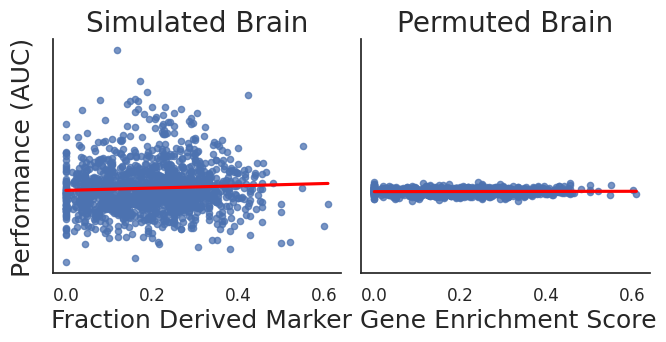

In [251]:
# def plot_enrichment_lm(data, marker_score:str):
#     # Set the plot style
#     sns.set_style('white')

#     data[marker_score] = pd.to_numeric(data[marker_score], errors='coerce')
    
#     # Create an lmplot with the specified marker score column
#     if marker_score != "fraction":
#         data[f"log_{marker_score}"] = np.log(data[marker_score]) # get log score
#         fg = sns.lmplot(
#             data=data,
#             x=f"log_{marker_score}",  # Use the marker_score variable as the x-axis
#             y="auc",
#             hue="enrichment",
#             col='exp_type',
#             col_order=['exp', 'cntrl'],
#             ci=None,
#             scatter_kws={'alpha': 0.75, "s": 20},
#             legend=False,
#         )
#     elif marker_score == "fraction":
#         fg = sns.lmplot(
#             data=data,
#             x=marker_score,  # Use the marker_score variable as the x-axis
#             y="auc",
#             hue="enrichment",
#             col='exp_type',
#             col_order=['exp', 'cntrl'],
#             ci=None,
#             scatter_kws={'alpha': 0.75, "s": 20},
#             legend=False,
#         )

#     # Set axis labels and scale
#     fg.set_axis_labels(x_var='', y_var='Performance (AUC)', fontsize=18)

#     # Adjust y-axis tick label font size and set titles
#     for ax in fg.axes.flatten():
#         ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

#     # Set subplot titles
#     axes = fg.axes.flatten()
#     axes[0].set_title("Simulated Brain", fontsize=20)
#     axes[1].set_title("Permuted Brain", fontsize=20)

#     # Add a text annotation for the x-axis based on marker_score
#     if marker_score == 'diff_MGES':
#         plt.text(x=-2.3, y=0.225, s=r"Log$_{10}$ Difference Marker Gene Enrichment Score", fontsize=18)
#     elif marker_score == 'logfc_MGES':
#         plt.text(x=-1, y=0.225, s=r"Log$_{10}$ Log$_2$Fold Change Marker Gene Enrichment Score", fontsize=18)
#     elif marker_score == 'wilcox_MGES':
#         plt.text(x=-2, y=0.225, s=r"Log$_{10}$ Wilcoxon Derived Marker Gene Enrichment Score", fontsize=18)
#     elif marker_score == 'fraction':
#         plt.text(x=-0.5, y=0.225, s=r"Fraction Derived Marker Gene Enrichment Score", fontsize=18)
    
#     # Customize the legend
#     handles, labels = fg.axes[0][0].get_legend_handles_labels()
#     custom_labels = ['Neither', 'Brain', 'PBMC']  # Update according to your data
#     legend = plt.legend(
#         handles,
#         custom_labels,
#         title='GO Term Category',
#         bbox_to_anchor=(0.65, 0.85),
#         loc='upper left',
#         markerscale=1.75
#     )
#     legend.get_title().set_fontsize(18)  # Set legend title font size
#     for text in legend.get_texts():
#         text.set_fontsize('16') 
#     plt.savefig(f"final/Enrichment_marker_score_correlations_{marker_score}.png", bbox_inches='tight', dpi = 300)

def plot_enrichment_lm(data, marker_score:str):
    # Set the plot style
    sns.set_style('white')

    data[marker_score] = pd.to_numeric(data[marker_score], errors='coerce')
    
    # Create an lmplot with the specified marker score column
    if marker_score != "fraction":
        data[f"log_{marker_score}"] = np.log(data[marker_score]) # get log score
        fg = sns.lmplot(
            data=data,
            x=f"log_{marker_score}",  # Use the marker_score variable as the x-axis
            y="auc",
            col='exp_type',
            col_order=['exp', 'cntrl'],
            ci=None,
            scatter_kws={'alpha': 0.75, "s": 20},
            legend=False,
            line_kws={'color':'red'},
            height = 3.5,
            aspect=1
        )
    elif marker_score == "fraction":
        fg = sns.lmplot(
            data=data,
            x=marker_score,  # Use the marker_score variable as the x-axis
            y="auc",
            col='exp_type',
            col_order=['exp', 'cntrl'],
            ci=None,
            scatter_kws={'alpha': 0.75, "s": 20},
            legend=False,
            line_kws={'color':'red'},
            height =3.5,
            aspect=1

        )

    # Set axis labels and scale
    fg.set_axis_labels(x_var='', y_var='Performance (AUC)', fontsize=18)

    # Adjust y-axis tick label font size and set titles
    for ax in fg.axes.flatten():
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

    # Set subplot titles
    axes = fg.axes.flatten()
    axes[0].set_title("Simulated Brain", fontsize=20)
    axes[1].set_title("Permuted Brain", fontsize=20)

    # Add a text annotation for the x-axis based on marker_score
    if marker_score == 'diff_MGES':
        plt.text(x=-2.3, y=0.225, s=r"Log$_{10}$ Brain Marker Gene Enrichment Score", fontsize=18)
    elif marker_score == 'logfc_MGES':
        plt.text(x=-2, y=0.2, s=r"Log$_{10}$ Log$_2$Fold Change Marker Gene Enrichment Score", fontsize=18)
    elif marker_score == 'wilcox_MGES':
        plt.text(x=-3.5, y=0.2, s=r"Log$_{10}$ Wilcoxon Derived Marker Gene Enrichment Score", fontsize=18)
    elif marker_score == 'fraction':
        plt.text(x=-0.75, y=0.2, s=r"Fraction Derived Marker Gene Enrichment Score", fontsize=18)
    
    # # Customize the legend
    # handles, labels = fg.axes[0][0].get_legend_handles_labels()
    # custom_labels = ['Neither', 'Brain', 'PBMC']  # Update according to your data
    # legend = plt.legend(
    #     handles,
    #     custom_labels,
    #     title='GO Term Category',
    #     bbox_to_anchor=(0.65, 0.85),
    #     loc='upper left',
    #     markerscale=1.75
    # )
    # legend.get_title().set_fontsize(18)  # Set legend title font size
    # for text in legend.get_texts():
    #     text.set_fontsize('16') 
    # plt.show()
    plt.savefig(f"final/Enrichment_marker_score_correlations_{marker_score}.png", bbox_inches='tight', dpi = 300)


# plot_enrichment_lm(MGES_model_graph, marker_score='diff_MGES') 
# plot_enrichment_lm(MGES_model_graph, marker_score='logfc_MGES')    
# plot_enrichment_lm(MGES_model_graph, marker_score='wilcox_MGES')     
plot_enrichment_lm(MGES_model_graph, marker_score='fraction')         

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='enrichment', ylabel='diff_MGES'>

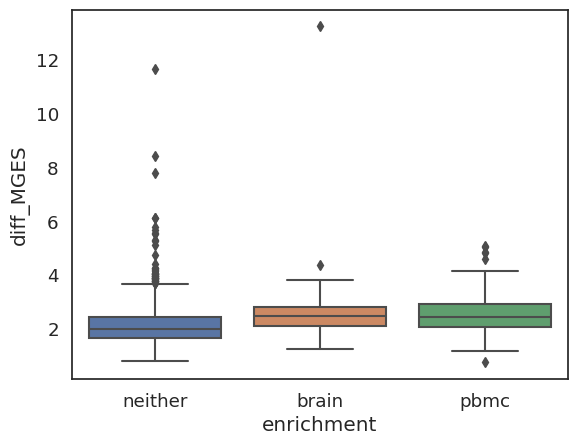

In [83]:
sns.boxplot(MGES_model_graph[MGES_model_graph.loc[:,'exp_type']=='exp'], x = 'enrichment', y = 'diff_MGES')

In [84]:
def fit_MGES_meta_model(MGES_model_graph):
    model = smf.ols('diff_MGES~enrichment', data = MGES_model_graph).fit()
    return model

MGES_model_graph['enrichment']=pd.Categorical(MGES_model_graph.loc[:,'enrichment'], ordered=True, categories=['neither','brain','pbmc'])
MGES_model_graph = MGES_model_graph[MGES_model_graph.loc[:,'exp_type']=='exp']
MGES_meta_model = fit_MGES_meta_model(MGES_model_graph=MGES_model_graph)
MGES_meta_model.summary()

/tmp/ipykernel_1964898/3457864995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MGES_model_graph['enrichment']=pd.Categorical(MGES_model_graph.loc[:,'enrichment'], ordered=True, categories=['neither','brain','pbmc'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diff_MGES   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     25.97
Date:                Mon, 02 Sep 2024   Prob (F-statistic):           8.43e-12
Time:                        11:14:00   Log-Likelihood:                -1729.6
No. Observations:                1396   AIC:                             3465.
Df Residuals:                    1393   BIC:                             3481.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.1497      0.024     87.863      0.000       2.102       2.198
enrichment[T.brain]     0.4599      0.086      5.327      0.000       0.291       0.629
enrichment[T.pbmc]      0.4161      0.078      5.307      0.000       0.262       0.570
==============================================================================
Omnibus:                     1247.675   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75453.071
Skew:                           3.877   Prob(JB):                         0.00
Kurtosis:                      38.172   Cond. No.                         3.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Also plot enrichment for Bulk

In [85]:
path_to_normal_brain = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkEGADPipeline/data/splitOPs1/EGAD/Brain_split.csv_bp_annotations_withGeneData_EGAD.csv"
df_normal_brain = pd.read_csv(path_to_normal_brain, sep = ",")
df_normal_brain.rename(columns={'auc':'bulk_auc'}, inplace = True)
# enrichment_performance_corr_df = enrichment_performance_corr_df.merge(df_normal_brain, left_on="id", right_index=True, how = 'inner')

In [86]:
# def plot_bulk_enrichment_lm(enrichment_performance_corr_df):
#     # Filter the DataFrame by 'exp_type'
#     filtered_df = enrichment_performance_corr_df[enrichment_performance_corr_df['exp_type'] == 'exp']
#     fig, ax1 = plt.subplots(1,1)
#     plot_lm(ax = ax1, x = filtered_df.loc[:,'marker_score'], y = filtered_df.loc[:,'bulk_auc'])
#     ax1.set_xlabel("Marker Score")
#     ax1.set_ylabel("Performance (AUC)")
#     plt.title("Correlation of Bulk Performance and \nMarker Gene Enrichment Score")
#     # Adjust layout to make sure all elements fit properly
#     plt.savefig("final/Enrichment_marker_score_bulk_correlations.png", bbox_inches='tight', dpi = 300)
    
# plot_bulk_enrichment_lm(enrichment_performance_corr_df=enrichment_performance_corr_df)
    


In [87]:
# sns.boxplot(enrichment_performance_corr_df, x = 'meta', y = 'marker_score')

# Investigating Cell Type Specific Expression Patterns of GO Terms that Performed Well and Poorly

In [88]:
# First, lets identify the top and bottom performing GO terms in each curated group
performance_master = performance_master[performance_master.loc[:,'exp_type'] == 'exp']

# Group by 'meta' and get the rows with the maximum 'auc' value for each group
top_auc_per_group = performance_master.groupby('meta').apply(lambda x: x.loc[x['auc'].idxmax()]).reset_index(drop=True)
print(top_auc_per_group)

bot_auc_per_group = performance_master.groupby('meta').apply(lambda x: x.loc[x['auc'].idxmin()]).reset_index(drop=True)
print(bot_auc_per_group)

        index  variance exp_type tissue       auc          id     meta
0  GO:0050911      0.05      exp  brain  0.814578  GO:0050911    Brain
1  GO:0007631      0.05      exp  brain  0.746516  GO:0007631  Neither
2  GO:0007159      0.05      exp  brain  0.602142  GO:0007159     PBMC
        index  variance exp_type tissue       auc          id     meta
0  GO:0048714      0.05      exp  brain  0.388752  GO:0048714    Brain
1  GO:0000423      0.05      exp  brain  0.344066  GO:0000423  Neither
2  GO:0016064      0.05      exp  brain  0.420789  GO:0016064     PBMC


In [89]:
# Load GO annotations to get genes in this gO term
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/final/bp_annotations_withGeneData_qc_annotations_no_dependance.csv")
# Load CT Profiles of Brain cell types
brain_cts = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bulkSimulationOneProfile/data/boot_run_feb29/4/CTProfiles/exp_brain_sc_with_metadata_pc_cpm_cell_type_profiles.csv", index_col=0)

In [90]:
# Creating a map from ENSG to symbol
adata = sc.read_h5ad("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessSC_pipe/data/h5ad_datasets/processed/cpm/brain_sc_with_metadata_pc_cpm.h5ad")
gene_map = adata.var.reset_index().loc[:,['ensembl_gene_id', 'hgnc_symbol']]

In [91]:
# adding gene map
df_all_scores = df_all_scores.merge(gene_map, left_on = 'names', right_on = 'hgnc_symbol')



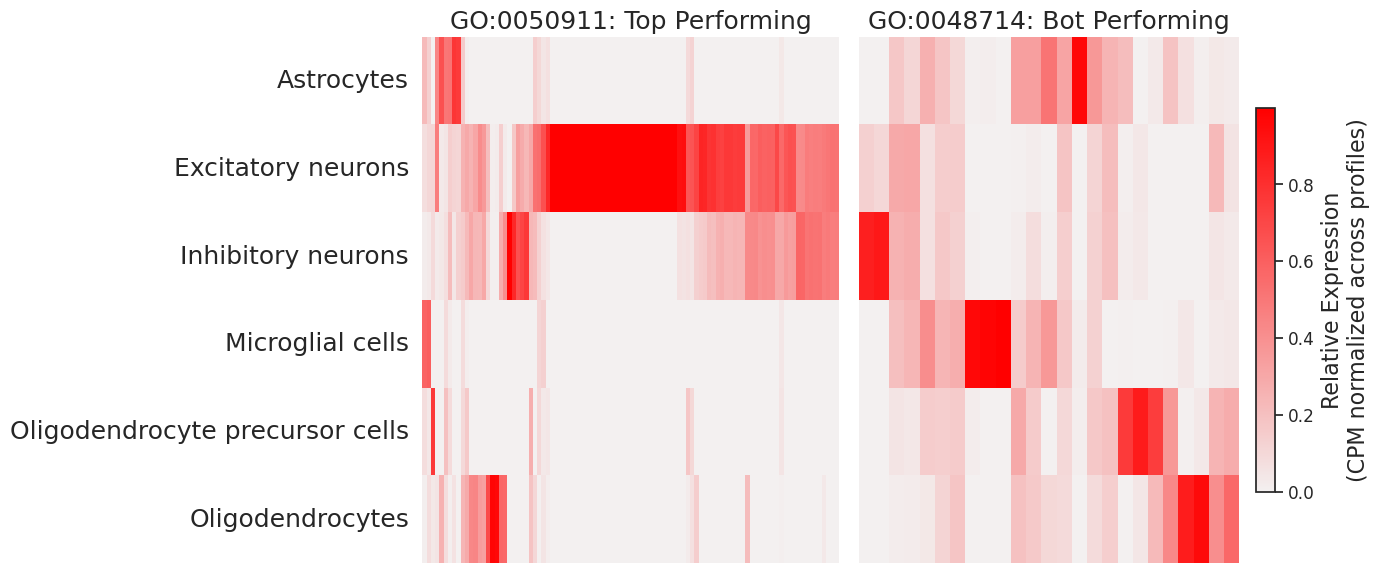

In [214]:
def graph_ct_profile_expression(exception_go:str, go_annot:pd.DataFrame, brain_cts:pd.DataFrame, df_all_scores:pd.DataFrame):
    """Graphs the cell type profiles of genes within a GO term    
    Args    
    	exception_go (str): go term id
    	go_annot (pd.DataFrame): df containing info about what genes are in what GO terms
    	brain_cts (pd.DataFrame): df of cell type profiles for genes
    """
    # Get the genes affiliated with GO term
    go_annot_filtered = go_annot[go_annot.loc[:,'GO ID'] == exception_go]
    
    # Subset the Brain CT Profile expression matrix by the genes in exception_go
    brain_cts_subset = brain_cts.loc[:,brain_cts.columns.isin(go_annot_filtered.ensembl_gene_id)]
    brain_cts_melted = brain_cts_subset.reset_index().melt(id_vars=['index'])
    # print(df_all_scores.shape)
    brain_cts_melted = brain_cts_melted.merge(df_all_scores, left_on=['index', 'variable'], right_on=['group','ensembl_gene_id'])
    brain_cts_melted.rename(columns= {'variable':'Genes',
                                       'index':"Cell Type"}, inplace=True)
    brain_heatmap = brain_cts_melted.loc[:,['Cell Type', 'Genes', "logfoldchanges"]].pivot(columns = 'Genes', index = 'Cell Type', values = 'logfoldchanges')
    
    # Create a diverging palette from blue to red
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Divide each column by the sum of each column
    # df_normalized = brain_cts_subset.div(brain_cts_subset.sum())
    # print(df_normalized.head())
    sns.set(font_scale=1.1)

    # Create the clustermap with customizations
    cg = sns.clustermap(brain_heatmap, 
                row_cluster=False,  # Remove row dendrogram
                col_cluster=True,  # Remove column dendrogram
                col_linkage=None,
                xticklabels=False,
                cmap=cmap,
                vmax=5,
                vmin=-5,
                cbar_pos=(0.06,0.3,0.03,0.25),
                cbar_kws={'label':"Log2 Fold Change In DEA",
                            "location":"left",
                            }
                )
    # Set x-label for the heatmap axis
    cg.ax_heatmap.set_xlabel("Genes", fontsize=20)

    # Hide the y-label if needed (empty string)
    cg.ax_heatmap.set_ylabel("")
    cg.fig.suptitle(f"Fold Change of Genes in {exception_go}",y = 0.85, size =20)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.savefig(f"final/go_enrichments/{exception_go.replace(':','_')}_fc.png", dpi=300)
    
# graph_ct_profile_expression("GO:0050911", go_annot=go_annot, brain_cts=brain_cts, df_all_scores=df_all_scores) # top brain
# graph_ct_profile_expression("GO:0048714", go_annot=go_annot, brain_cts=brain_cts, df_all_scores=df_all_scores) # bot brain

from matplotlib.colors import Normalize
def graph_both_profiles(lo_go_ids, go_annot: pd.DataFrame, brain_cts: pd.DataFrame, df_all_scores: pd.DataFrame):
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    

    def graph_one_profile(exception_go: str, go_annot: pd.DataFrame, brain_cts: pd.DataFrame, ax, title, add_colorbar):
            # Create a custom colormap ranging from red to white
        cmap = sns.light_palette("red", as_cmap=True)
        
        # Get the genes affiliated with GO term
        go_annot_filtered = go_annot[go_annot.loc[:,'GO ID'] == exception_go]

        
        # Subset the Brain CT Profile expression matrix by the genes in exception_go
        brain_cts_subset = brain_cts.loc[:,brain_cts.columns.isin(go_annot_filtered.ensembl_gene_id)]
        df_normalized = brain_cts_subset.div(brain_cts_subset.sum())
        # Create the heatmap with clustering
        # Scale the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df_normalized)
        
        # Perform hierarchical clustering for rows and columns
        col_linkage = linkage(scaled_data.T, method='centroid')
        
        # Get the order of rows and columns
        # row_order = leaves_list(row_linkage)
        col_order = leaves_list(col_linkage)
        
        # Reorder the data according to clustering
        df_normalized_clustered = df_normalized.iloc[:,col_order]
        

        # Plot the heatmap
        sns.heatmap(df_normalized_clustered, 
                    ax=ax,
                    cmap=cmap,  # Choose your colormap
                    cbar=False,
                    cbar_kws={'label': 'Value'},
                    annot=False)# Set to True if you want to show values in the heatmap
                    # xticklabels=df_normalized_clustered.columns[col_order],
                    # yticklabels=df_normalized_clustered.index[row_order])
        ax.set_title(title, fontsize=18)
        ax.set_xticks([])
        # Add colorbar manually if specified
        if add_colorbar:
            norm = Normalize(vmin=df_normalized.min().min(), vmax=df_normalized.max().max())
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
            cbar.set_label("Relative Expression\n(CPM normalized across profiles)", fontsize=16)


    
    for i, go in enumerate(lo_go_ids):
        ax = axes[i]
        if i == 0:
            title = f"{go}: Top Performing"
            add_colorbar=False
            graph_one_profile(exception_go=go, go_annot=go_annot, brain_cts=brain_cts, ax=ax, title = title, add_colorbar=add_colorbar)
            ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize=18)
        elif i == 1:
            title = f"{go}: Bot Performing"
            add_colorbar=True
            graph_one_profile(exception_go=go, go_annot=go_annot, brain_cts=brain_cts, ax=ax, title = title, add_colorbar=add_colorbar)
            ax.set_yticklabels([])
        
        
        

    plt.tight_layout()
    plt.savefig('final/top_and_bot_profiles.png', dpi = 300)

graph_both_profiles(["GO:0050911", "GO:0048714"], go_annot=go_annot, brain_cts=brain_cts, df_all_scores=df_all_scores, )
# graph_ct_profile_expression("GO:0007631", go_annot=go_annot, brain_cts=brain_cts, df_all_scores=df_all_scores)
# graph_ct_profile_expression("GO:0000423", go_annot=go_annot, brain_cts=brain_cts, df_all_scores=df_all_scores)
# graph_ct_profile_expression("GO:0007159", go_annot=go_annot, brain_cts=brain_cts,  df_all_scores=df_all_scores)
# graph_ct_profile_expression("GO:0016064", go_annot=go_annot, brain_cts=brain_cts,  df_all_scores=df_all_scores)

<Figure size 800x400 with 0 Axes>

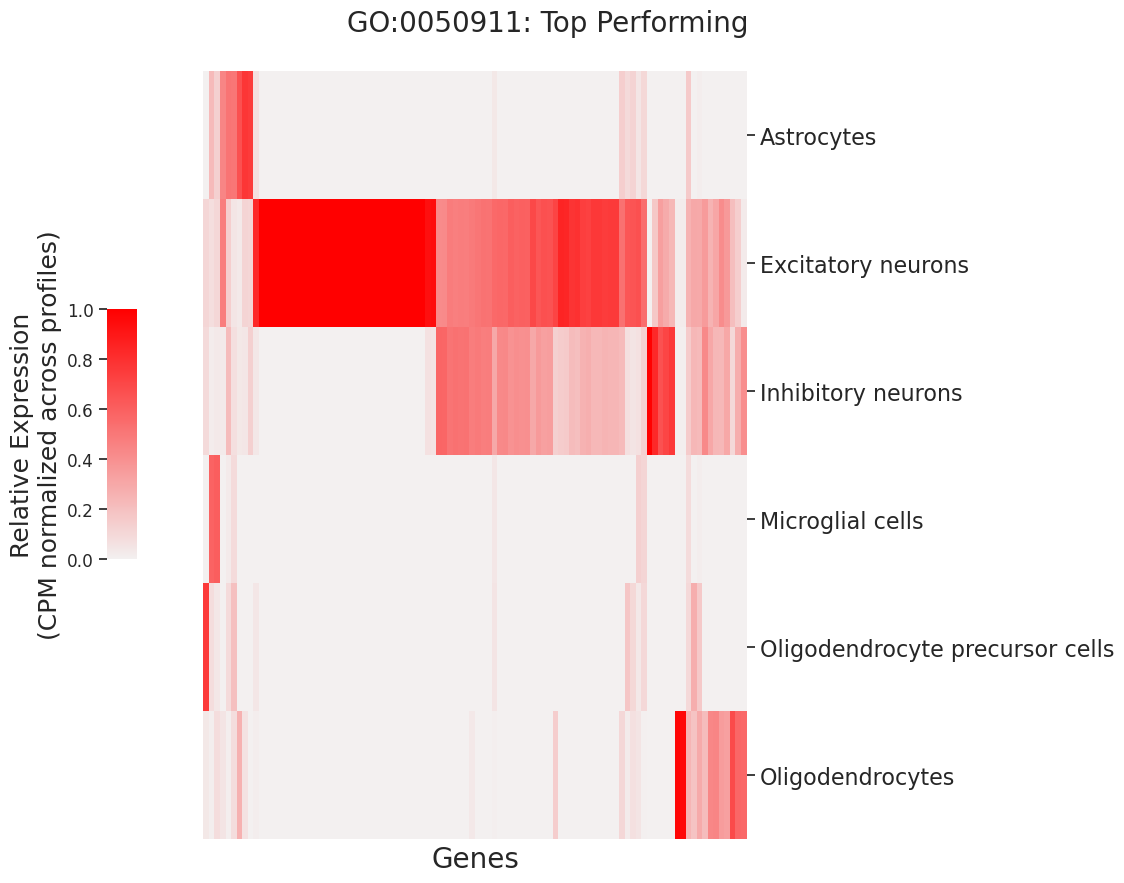

<Figure size 800x400 with 0 Axes>

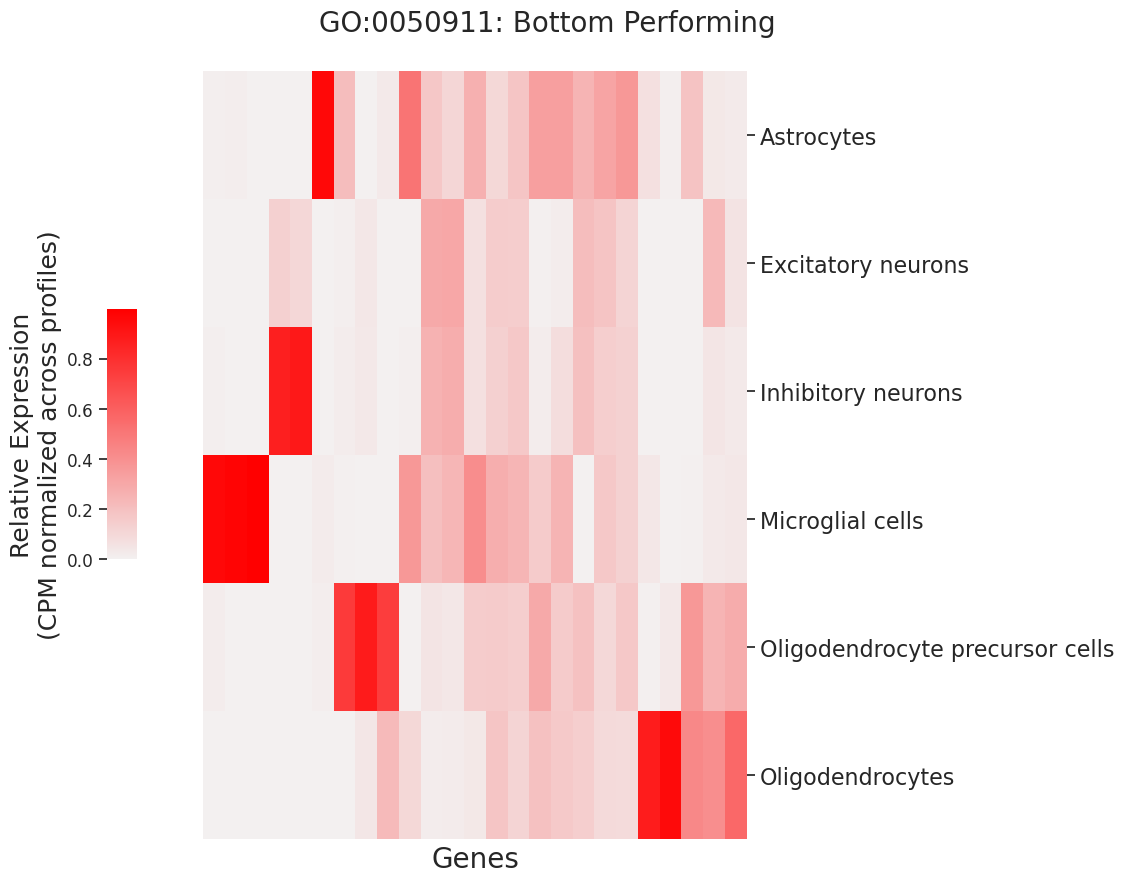

In [93]:
def graph_ct_profile_expression(exception_go:str, go_annot:pd.DataFrame, brain_cts:pd.DataFrame, title:str):
    """Graphs the cell type profiles of genes within a GO     
    Args:
    	exception_go (str): go term id
    	go_annot (pd.DataFrame): df containing info about what genes are in what GO terms
    	brain_cts (pd.DataFrame): df of cell type profiles for genes
    """
    # Get the genes affiliated with GO term
    go_annot_filtered = go_annot[go_annot.loc[:,'GO ID'] == exception_go]
    
    # Subset the Brain CT Profile expression matrix by the genes in exception_go
    brain_cts_subset = brain_cts.loc[:,brain_cts.columns.isin(go_annot_filtered.ensembl_gene_id)]
    
    # Create a custom colormap ranging from red to white
    cmap = sns.light_palette("red", as_cmap=True)

    # Divide each column by the sum of each column
    df_normalized = brain_cts_subset.div(brain_cts_subset.sum())
    sns.set(font_scale=1.1)
    # Set the size of the figure
    plt.figure(figsize=(8, 4))  # Adjust width and height as needed
    # Create the clustermap with customizations
    cg = sns.clustermap(df_normalized, 
                row_cluster=False,  # Remove row dendrogram
                col_cluster=True,  # Remove column dendrogram
                col_linkage=None,
                xticklabels=False,
                cmap=cmap,
                cbar_pos=(0.06,0.3,0.03,0.25),
                cbar_kws={'label':"Relative Expression\n(CPM normalized across profiles)",
                            "location":"left",
                            })
    cb = cg.ax_cbar
    cb.set_ylabel("Relative Expression\n(CPM normalized across profiles)", fontsize=18)
    # Access the x-axis label and set its properties
    cg.ax_heatmap.set_xlabel('Genes', fontsize=20)
    
    ax = cg.ax_heatmap
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

    # cg.set_ylabel("")
    cg.fig.suptitle(title,y = 0.85, size =20)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.savefig(f"final/go_enrichments/{exception_go.replace(':','_')}_expression.png", dpi=300)



graph_ct_profile_expression("GO:0050911", go_annot=go_annot, brain_cts=brain_cts, title = "GO:0050911: Top Performing")# top brain)
graph_ct_profile_expression("GO:0048714", go_annot=go_annot, brain_cts=brain_cts, title = "GO:0050911: Bottom Performing") # bot brain
# graph_ct_profile_expression("GO:0007631", go_annot=go_annot, brain_cts=brain_cts)
# graph_ct_profile_expression("GO:0000423", go_annot=go_annot, brain_cts=brain_cts)
# graph_ct_profile_expression("GO:0007159", go_annot=go_annot, brain_cts=brain_cts)
# graph_ct_profile_expression("GO:0016064", go_annot=go_annot, brain_cts=brain_cts)

# mean(cpm)

# so I took my CPM for my cell type profiles. So these are already normalized by the librazy size

# Removing Microglial Cells Removes PBMC Performance

Purpose:

We showed that simulating bulk with CT Profiles, then taking coexpression, then performing function prediction results in an increase in performance of CT Related terms. When simulating bulk PBMC, PBMC GO term performance increased. When simulating bulk brain, Brain and PBMC term performance increased. We just saw that the top performing PBMC GO term for the Brian data has CT Specific Expression patterns, in particular it is highly expressed in microglia. This suggests that perhaps there is significant gene overlap in PBMC and Microglial expressed genes, which would lead to microglial cell type profiles increasing performance. To further display the effect that compV can have on cell type specific performance, we simulated bulk briain without microglial cells. This resulted in the PBMC GO terms that had genes that were expressed in those microglial cell type profiles  -- performance to decrease

In [94]:
# load df of performance with brain withuot microglial cells
micro_rem = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bulkSimulationOneProfile/data/boot_brain_rm_100/master_melted_df.csv.gz")

# Filter for desired information
micro_rem= micro_rem[micro_rem['variance'] == 0.05]
micro_rem['exp_type'] = micro_rem.organism_part.str.split("_").str.get(0)
micro_rem['tissue'] = micro_rem.organism_part.str.split("_").str.get(1)
# Calc stats
# Group by 'index', 'variance', 'exp_type', and 'tissue', calculate mean and std of 'auc'
micro_rem_grouped = micro_rem.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].agg(['mean', 'std']).reset_index()
# Rename columns for clarity
micro_rem_grouped.rename(columns={'mean': 'micro_auc', 'std': 'micro_std_auc'}, inplace=True)

In [95]:
micro_rem_performance_master = performance_master.merge(micro_rem_grouped[micro_rem_grouped.loc[:,'exp_type']=="exp"], left_on='index', right_on='index').loc[:,['index', 'auc', 'meta', 'micro_auc']]

In [96]:
top_performing_PBMC = micro_rem_performance_master[micro_rem_performance_master.loc[:,'meta']=='PBMC'].sort_values('auc', ascending=False).head(20)
top_performing_PBMC_melt = top_performing_PBMC.loc[:,['index', 'auc', 'micro_auc']].melt(id_vars = 'index')
top_performing_PBMC_melt.head()

,index,variable,value
0,GO:0007159,auc,0.602142
1,GO:0001916,auc,0.598536
2,GO:0050901,auc,0.596032
3,GO:0032753,auc,0.590284
4,GO:0002682,auc,0.584439


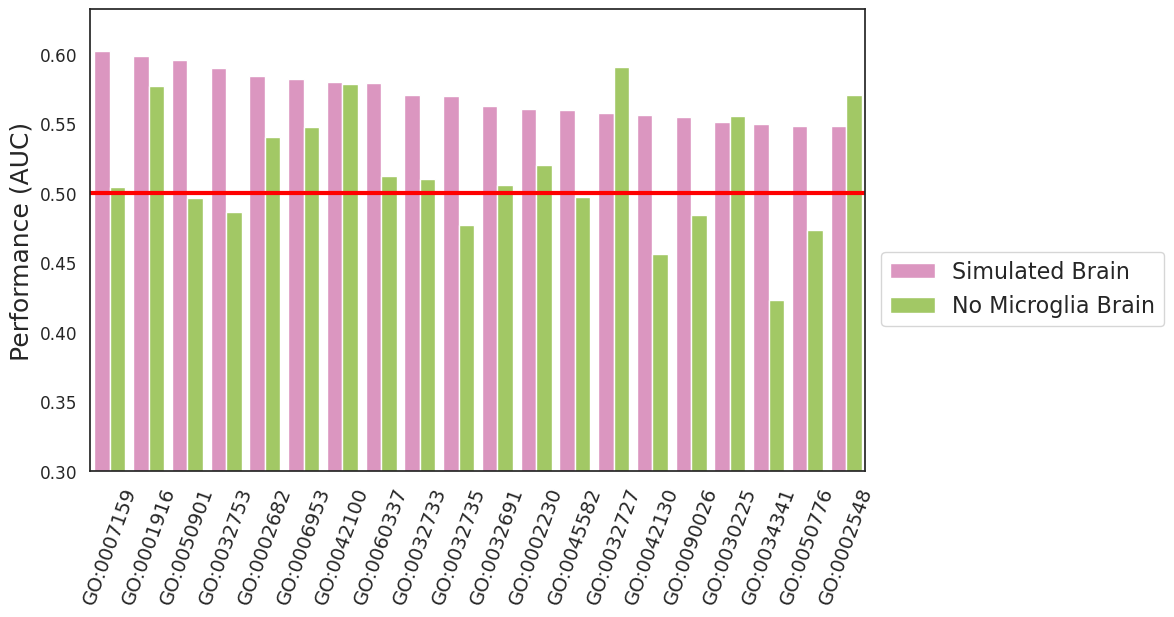

In [97]:
# Set style and create bar plot
sns.set_style('white')
palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

top_performing_PBMC_melt['variable'] = top_performing_PBMC_melt["variable"].replace({
    'auc': "Simulated Brain",
    'micro_auc': "No Microglia Brain"
})

# Create the bar plot
ax = sns.barplot(data=top_performing_PBMC_melt, x='index', y='value', hue='variable', palette=palette[3:5])
plt.axhline(y=0.5, color='red', linestyle='-', lw=3)  # Adding horizontal line

# Adjust y-axis limits
ax.set_ylim(0.3, ax.get_ylim()[1])  # Set y-axis to start at 0.3

# Adding labels and title
plt.xlabel('')
plt.ylabel('Performance (AUC)', fontsize=18)
plt.xticks(fontsize=14, rotation=70)
plt.legend(title='', loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 0.5))

# Save the plot
plt.savefig("final/Performance_micro_remove.png", bbox_inches='tight')


# Correlating Bulk Performance with CT Performance

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import linregress

In [99]:
path_to_normal_brain = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkEGADPipeline/data/splitOPs1/EGAD/Brain_split.csv_bp_annotations_withGeneData_EGAD.csv"
# path_to_normal_pbmc = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkEGADPipeline/data/splitOPs1/EGAD/Blood_split.csv_bp_annotations_withGeneData_EGAD.csv"

In [100]:
df_normal_brain = pd.read_csv(path_to_normal_brain, sep = ",")
df_normal_brain['tissue']= "brain"
df_normal_brain.rename(columns={'auc':'bulk_auc'}, inplace = True)

# df_normal_blood = pd.read_csv(path_to_normal_pbmc, sep = ",")
# df_normal_blood['tissue']= "pbmc"
# df_normal_blood.rename(columns={'auc':'bulk_auc'}, inplace = True)

# df_normal = pd.concat([df_normal_blood, df_normal_brain], axis = 0 ).reset_index()

In [101]:
# Load GO Term performance Master
performance_master = pd.read_csv("data/GO_performances_filtered.csv", index_col=0)
performance_master = performance_master[performance_master.loc[:,'tissue']=='brain']
df_normal_brain  = pd.merge(performance_master, df_normal_brain.reset_index(), left_on='index', right_on='index')

In [102]:
df_normal_brain

,index,variance,exp_type,tissue_x,auc,id,meta,bulk_auc,avg_node_degree,degree_null_auc,tissue_y
0,GO:0000045,0.05,cntrl,brain,0.495079,GO:0000045,Neither,0.510158,5030.002648,0.678506,brain
1,GO:0000045,0.05,exp,brain,0.545295,GO:0000045,Neither,0.510158,5030.002648,0.678506,brain
2,GO:0000070,0.05,cntrl,brain,0.505884,GO:0000070,Neither,0.724413,4511.111251,0.593200,brain
3,GO:0000070,0.05,exp,brain,0.500938,GO:0000070,Neither,0.724413,4511.111251,0.593200,brain
4,GO:0000077,0.05,cntrl,brain,0.486789,GO:0000077,Neither,0.556489,5026.911759,0.675227,brain
...,...,...,...,...,...,...,...,...,...,...,...
2781,GO:2001240,0.05,exp,brain,0.477814,GO:2001240,Neither,0.634854,3152.962389,0.409356,brain
2782,GO:2001243,0.05,cntrl,brain,0.504440,GO:2001243,Neither,0.497088,4564.835473,0.601020,brain
2783,GO:2001243,0.05,exp,brain,0.535729,GO:2001243,Neither,0.497088,4564.835473,0.601020,brain
2784,GO:2001244,0.05,cntrl,brain,0.494293,GO:2001244,Neither,0.650513,3838.423294,0.506829,brain


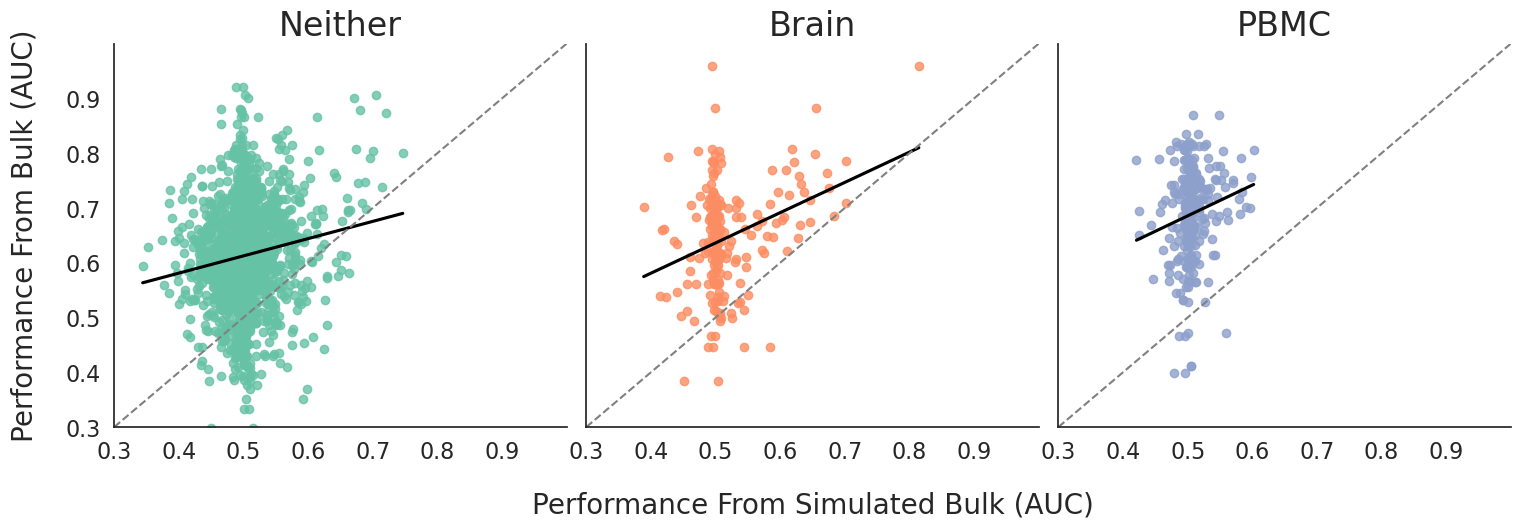

In [103]:
def plot_bulk_comparision(df_normal_brain):
    # Create the lmplot
    palette = sns.color_palette("Set2")
    g = sns.lmplot(data=df_normal_brain,
                x='auc',
                y='bulk_auc',
                col='meta',
                hue='meta',
                palette=palette,
                facet_kws = {"sharex":True, "sharey":True},
                line_kws={'color': 'black'},
                ci=None
                )


    # Function to plot diagonal line
    def plot_diagonal_line(ax):
        ax.plot([0.3, 1], [0.3, 1], color='grey', linestyle='--')
        
    def plot_correlation(ax, facet_data):
        spearman = facet_data.loc[:,'bulk_auc'].corr(facet_data.loc[:,'auc'], method = "spearman")
        ax.annotate(f"Spearmanr {spearman:.2f}", fontsize=18, color='black', xy=(0.05, 0.87), xycoords='axes fraction')

    
    
    # for i, ax in enumerate(g.axes):
    #     print(ax)
    #     facet_data = df_normal_brain[(df_normal_brain['meta'] == g.col_names[i])]
    #     slope, intercept, _, p_value, _ = linregress(facet_data['auc'], facet_data['bulk_auc'])
    #     plot_diagonal_line(ax)
    #     ax.annotate(f"y = {slope:.2f}x + {round(intercept, 2)}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='black')
    #     ax.set(xlim=(0.3, 1), ylim=(0.3, 1))
    # Iterate over each row and column in the facet grid
    for i, row in enumerate(g.axes):
        for j, ax in enumerate(row):
            # Extract data for the current facet
            facet_data = df_normal_brain[(df_normal_brain['meta'] == g.col_names[j])]
            
            # Fit linear regression
            slope, intercept, _, p_value, _ = linregress(facet_data['auc'], facet_data['bulk_auc'])
            
            # Plot the diagonal line
            plot_diagonal_line(ax)
            
            # Plot the correlation coefficient
            # plot_correlation(ax, facet_data)
            
            # Annotate slope onto the plot

            # ax.annotate(f"AUC = {slope:.2f}x + {round(intercept, 2)}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=18, color='black')
            
            # Set the same scale for X and Y axes across all plots
            ax.set(xlim=(0.3, 1), ylim=(0.3, 1))
            
            ax.set_title(f"{g.col_names[j]}", fontsize=24)
            # ax.set_xlabel("Performance From Simulated Bulk (AUC)")
            
            if j == 0:
                ax.set_ylabel("Performance From Bulk (AUC)", fontsize = 20, labelpad=20)
                ax.set_yticks(ticks =[0.3,0.4,0.5,0.6,0.7,0.8,0.9], labels = [0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=16)
                ax.set_xticks(ticks =[0.3,0.4,0.5,0.6,0.7,0.8,0.9], labels = [0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=16)
            if j == 1:
                ax.set_xlabel("Performance From Simulated Bulk (AUC)", fontsize = 20, labelpad=20)
                ax.set_xticks(ticks =[0.3,0.4,0.5,0.6,0.7,0.8,0.9], labels = [0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=16)
            else:
                ax.set_xlabel('')
                ax.set_xticks(ticks =[0.3,0.4,0.5,0.6,0.7,0.8,0.9], labels = [0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=16)

                
        # Save the plot
    plt.savefig("final/bulk_corr.png", dpi=300, bbox_inches='tight')
    
plot_bulk_comparision(df_normal_brain=df_normal_brain)


# Stats

Make a lm for each tissue in the form:

bulk performance ~ simulated performance * GO affiliation

In [104]:
import patsy
import statsmodels.api as sm

In [105]:
def fit_model_bulk_sc(df_master, tissue:str):
    # df_master = df_master[df_master.tissue==tissue]
    
    # Creating design matrix
    meta_levels = ["Neither", "Brain","PBMC"]

    y,X = patsy.dmatrices('bulk_auc ~ auc * C(meta, levels = meta_levels)', data = df_master)
    
    # Linear model
    model = sm.OLS(y, X).fit()
    
    return model

In [106]:
brain_model = fit_model_bulk_sc(df_master=df_normal_brain, tissue = "brain")
brain_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               bulk_auc   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     55.28
Date:                Mon, 02 Sep 2024   Prob (F-statistic):           6.54e-55
Time:                        11:14:54   Log-Likelihood:                 2922.5
No. Observations:                2786   AIC:                            -5833.
Df Residuals:                    2780   BIC:                            -5797.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.4551      0.024     18.693      0.000       0.407       0.503
C(meta, levels=meta_levels)[T.Brain]        -0.0952      0.060     -1.591      0.112      -0.213       0.022
C(meta, levels=meta_levels)[T.PBMC]         -0.0502      0.105     -0.476      0.634      -0.257       0.157
auc                                          0.3150      0.048      6.521      0.000       0.220       0.410
auc:C(meta, levels=meta_levels)[T.Brain]     0.2377      0.115      2.060      0.039       0.011       0.464
auc:C(meta, levels=meta_levels)[T.PBMC]      0.2466      0.208      1.187      0.235      -0.161       0.654
==============================================================================
Omnibus:                       32.663   Durbin-Watson:                   0.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.427
Skew:                          -0.077   Prob(JB):                     4.13e-12
Kurtosis:                       3.654   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
df_normal_brain

,index,variance,exp_type,tissue_x,auc,id,meta,bulk_auc,avg_node_degree,degree_null_auc,tissue_y
0,GO:0000045,0.05,cntrl,brain,0.495079,GO:0000045,Neither,0.510158,5030.002648,0.678506,brain
1,GO:0000045,0.05,exp,brain,0.545295,GO:0000045,Neither,0.510158,5030.002648,0.678506,brain
2,GO:0000070,0.05,cntrl,brain,0.505884,GO:0000070,Neither,0.724413,4511.111251,0.593200,brain
3,GO:0000070,0.05,exp,brain,0.500938,GO:0000070,Neither,0.724413,4511.111251,0.593200,brain
4,GO:0000077,0.05,cntrl,brain,0.486789,GO:0000077,Neither,0.556489,5026.911759,0.675227,brain
...,...,...,...,...,...,...,...,...,...,...,...
2781,GO:2001240,0.05,exp,brain,0.477814,GO:2001240,Neither,0.634854,3152.962389,0.409356,brain
2782,GO:2001243,0.05,cntrl,brain,0.504440,GO:2001243,Neither,0.497088,4564.835473,0.601020,brain
2783,GO:2001243,0.05,exp,brain,0.535729,GO:2001243,Neither,0.497088,4564.835473,0.601020,brain
2784,GO:2001244,0.05,cntrl,brain,0.494293,GO:2001244,Neither,0.650513,3838.423294,0.506829,brain


In [108]:
brain_model.pvalues

array([1.52144696e-73, 1.11823212e-01, 6.34064225e-01, 8.24587433e-11,
       3.94749588e-02, 2.35423086e-01])

# Bulk Composition Effects Removal


Purpose:

If we remove the composition effects from bulk brain and PBMC via regressing out the Marker gene profiles, we expect the performance of GO terms affiliated with those marker gene profiles to decrease in performance


In [185]:
def load_regressed_performance(path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/data/dev/july_boot_29")->pd.DataFrame:
    """Loads performance from 62 simulations where composition variance from brain markers was regressed out

    Args:
        path (str, optional): path to regression performance directory

    Returns:
        pd.DataFrame: Dataframe that has performance for bulk brain with regressed comp
    """

    lo_dirs = os.listdir("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/data/dev/july_boot_28")
    lo_potential_files = [f"{path}/{dir}/melted_EGAD.csv" for dir in lo_dirs]

    def filter_existing_paths(paths):
        """Filter out paths that do not exist."""
        existing_paths = [path for path in paths if os.path.exists(path)]
        return existing_paths
    lo_files = filter_existing_paths(lo_potential_files)
    
    lo_dfs = [pd.read_csv(file, index_col=0) for file in lo_files]

    def add_boot_col(lo_dfs):
        lo_new_dfs = []
        for i,df in enumerate(lo_dfs):
            df['boot']=i
            lo_new_dfs.append(df)
        return lo_new_dfs
    lo_dfs = add_boot_col(lo_dfs=lo_dfs)
    
    df = pd.concat(lo_dfs, axis = 0)
    # df_grouped = df.reset_index().groupby(by = ['index', 'tissue', 'type'])['auc'].mean().reset_index()
    return df #df_grouped

df_no_comp_effects = load_regressed_performance()
df_no_comp_effects.head()

,auc,avg_node_degree,degree_null_auc,tissue,reg_ct,type,boot
GO:0000045,0.563325,63.249541,0.481147,Brain,brain,random,0
GO:0000070,0.684876,69.735518,0.554773,Brain,brain,random,0
GO:0000077,0.507180,66.893500,0.602790,Brain,brain,random,0
GO:0000079,0.513177,59.288797,0.557152,Brain,brain,random,0
GO:0000082,0.492974,102.430985,0.538646,Brain,brain,random,0


In [188]:
len(df_no_comp_effects.boot.unique())

69

In [189]:
# def process_no_comp_df(df_no_comp_effects:pd.DataFrame, GO_curations:pd.DataFrame)->pd.DataFrame:
#     """
#     Coerce dataframe to be nice, and add metadata for GO term cell type relatedness
#     """
#     df_wide_no_comp = df_no_comp_effects.pivot(index = 'index', columns = ['tissue','type'], values = 'auc').reset_index()
#     df_wide_no_comp.columns = df_wide_no_comp.columns.droplevel(level=0)
#     df_wide_no_comp.columns = ['id', 'brain_markers', 'brain_rand']
#     df_wide_no_comp = df_wide_no_comp.merge(GO_curations, left_on='id', right_on = 'id')
#     df_wide_no_comp = df_wide_no_comp.loc[:,['id', "brain_markers", "brain_rand", "meta"]]
#     return df_wide_no_comp

# df_wide_no_comp = process_no_comp_df(df_no_comp_effects, GO_curations)
# df_wide_no_comp.head()

df_no_comp_effects_melted = df_no_comp_effects.merge(GO_curations, left_index=True, right_on='id').loc[:,['id','meta','boot','type','auc']]
df_no_comp_effects.head()

,auc,avg_node_degree,degree_null_auc,tissue,reg_ct,type,boot
GO:0000045,0.563325,63.249541,0.481147,Brain,brain,random,0
GO:0000070,0.684876,69.735518,0.554773,Brain,brain,random,0
GO:0000077,0.507180,66.893500,0.602790,Brain,brain,random,0
GO:0000079,0.513177,59.288797,0.557152,Brain,brain,random,0
GO:0000082,0.492974,102.430985,0.538646,Brain,brain,random,0


In [190]:
df_no_comp_effects_melted

,id,meta,boot,type,auc
0,GO:0000045,Neither,0,random,0.563325
0,GO:0000045,Neither,0,markers,0.552550
0,GO:0000045,Neither,1,markers,0.549692
0,GO:0000045,Neither,1,random,0.559001
0,GO:0000045,Neither,2,markers,0.477246
...,...,...,...,...,...
1395,GO:2001244,Neither,66,random,0.568158
1395,GO:2001244,Neither,67,random,0.530914
1395,GO:2001244,Neither,67,markers,0.640012
1395,GO:2001244,Neither,68,random,0.470705


In [193]:
# melt
# df_melted_no_comp = df_wide_no_comp.melt(id_vars=['id','meta'])

In [194]:
df_no_comp_effects_melted.reset_index().groupby(by = ['id', 'meta', 'type'])['auc'].mean().reset_index()

,id,meta,type,auc
0,GO:0000045,Neither,markers,0.532878
1,GO:0000045,Neither,random,0.546731
2,GO:0000070,Neither,markers,0.668318
3,GO:0000070,Neither,random,0.686037
4,GO:0000077,Neither,markers,0.565770
...,...,...,...,...
2787,GO:2001240,Neither,random,0.531009
2788,GO:2001243,Neither,markers,0.594283
2789,GO:2001243,Neither,random,0.558870
2790,GO:2001244,Neither,markers,0.622794


In [195]:
df_no_comp_effects_melted

,id,meta,boot,type,auc
0,GO:0000045,Neither,0,random,0.563325
0,GO:0000045,Neither,0,markers,0.552550
0,GO:0000045,Neither,1,markers,0.549692
0,GO:0000045,Neither,1,random,0.559001
0,GO:0000045,Neither,2,markers,0.477246
...,...,...,...,...,...
1395,GO:2001244,Neither,66,random,0.568158
1395,GO:2001244,Neither,67,random,0.530914
1395,GO:2001244,Neither,67,markers,0.640012
1395,GO:2001244,Neither,68,random,0.470705


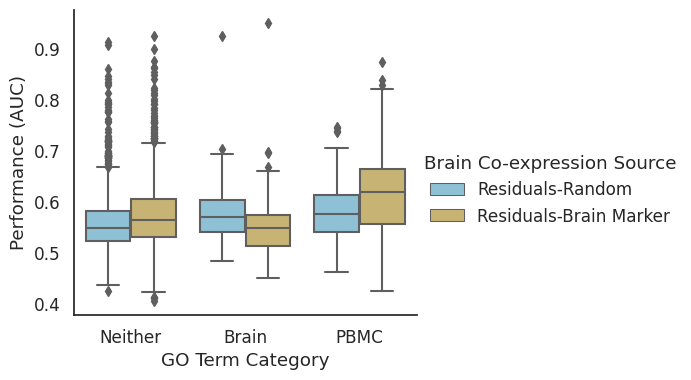

In [196]:
def plot_regressed_comparison(df_melted_no_comp_final):
    sns.set_style('white')
    palette = sns.color_palette('muted')[::-1]
    legend_name = "Brain Co-expression Source"
    df_melted_no_comp_final = df_melted_no_comp_final.rename(columns={'type':legend_name})
    # Mapping dictionary
    mapping = {
        # "auc_bulk": "Bulk",
        "markers": "Residuals-Brain Marker",
        "random": "Residuals-Random"
    }
    # Replace values in the column
    df_melted_no_comp_final.loc[:,legend_name] = df_melted_no_comp_final.loc[:,legend_name].replace(mapping)

    df_melted_no_comp_final[legend_name] = pd.Categorical(df_melted_no_comp_final[legend_name], ordered=True, categories=[ "Residuals-Random", "Residuals-Brain Marker"]) # categories=["Bulk", "Residuals-Random", "Residuals-Brain Marker"]
    # # Using sns.catplot for facetting
    g = sns.catplot(data=df_melted_no_comp_final, x = 'meta', y='auc', hue=f"{legend_name}", kind='box', height=4, aspect=1.2, palette=palette)
    g.set_axis_labels(x_var="GO Term Category", y_var = "Performance (AUC)")
    
    plt.savefig('final/comp_effect_removed.png', dpi = 300, bbox_inches='tight')
    plt.show()

plot_regressed_comparison(df_no_comp_effects_melted.reset_index().groupby(by = ['id', 'meta', 'type'])['auc'].mean().reset_index())

# Stats

In [197]:
def fit_mixed_model_no_compv(Reg_model_df_melted):
    # Defining the levels for categorical variables
    Reg_model_df_melted['meta'] = pd.Categorical(Reg_model_df_melted.loc[:,'meta'], categories = ["Neither", "Brain", "PBMC"], ordered=True)
    Reg_model_df_melted['coexpression'] = pd.Categorical(Reg_model_df_melted.loc[:,'type'], categories = ['random', 'markers'], ordered=True)
    
    # Creating the formula for the mixed-effects model
    formula = 'auc ~  meta * coexpression'
    
    # Fitting the mixed-effects model using smf.mixedlm
    # 'index' is specified as the grouping variable for random effects
    model = smf.mixedlm(formula, data=Reg_model_df_melted, groups = Reg_model_df_melted['boot'], re_formula='~coexpression')
    mixed_model_fit = model.fit()

    return mixed_model_fit
    
compV_removed_model = fit_mixed_model_no_compv(df_no_comp_effects_melted)
compV_removed_model.summary()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                    MixedLM         Dependent Variable:         auc        
No. Observations:         192648          Method:                     REML       
No. Groups:               69              Scale:                      0.0058     
Min. group size:          2792            Log-Likelihood:             223180.7459
Max. group size:          2792            Converged:                  Yes        
Mean group size:          2792.0                                                 
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              0.558    0.001 978.020 0.000  0.557  0.559
meta[T.Brain]                          0.018    0.001  19.035 0.000  0.016  0.020
meta[T.PBMC]                           0.024    0.001  27.502 0.000  0.022  0.025
coexpression[T.markers]                0.016    0.001  25.870 0.000  0.015  0.018
meta[T.Brain]:coexpression[T.markers] -0.039    0.001 -29.086 0.000 -0.041 -0.036
meta[T.PBMC]:coexpression[T.markers]   0.021    0.001  17.072 0.000  0.018  0.023
Group Var                              0.000    0.000                            
Group x coexpression[T.markers] Cov   -0.000    0.000                            
coexpression[T.markers] Var            0.000    0.000                            
=================================================================================

"""

In [198]:
compV_removed_model.pvalues

Intercept                                 0.000000e+00
meta[T.Brain]                             8.820914e-81
meta[T.PBMC]                             1.680014e-166
coexpression[T.markers]                  1.438492e-147
meta[T.Brain]:coexpression[T.markers]    5.464323e-186
meta[T.PBMC]:coexpression[T.markers]      2.393206e-65
Group Var                                 1.906825e-06
Group x coexpression[T.markers] Cov       3.220746e-04
coexpression[T.markers] Var               1.643109e-02
dtype: float64

### Fit model for bMGES and comp removal

In [199]:
MGES_model_meta = MGES_model_df.loc[:,['index','meta','wilcox_MGES', 'logfc_MGES','diff_MGES','fraction']].drop_duplicates()
MGES_reg_model_df = MGES_model_meta.merge(df_no_comp_effects_melted, left_on = ['index', 'meta'], right_on=['id','meta'])
MGES_reg_model_df.head()

,index,meta,wilcox_MGES,logfc_MGES,diff_MGES,fraction,id,boot,type,auc,coexpression
0,GO:0000045,Neither,1.683795,1.314959,1.738638,0.079365,GO:0000045,0,random,0.563325,random
1,GO:0000045,Neither,1.683795,1.314959,1.738638,0.079365,GO:0000045,0,markers,0.552550,markers
2,GO:0000045,Neither,1.683795,1.314959,1.738638,0.079365,GO:0000045,1,markers,0.549692,markers
3,GO:0000045,Neither,1.683795,1.314959,1.738638,0.079365,GO:0000045,1,random,0.559001,random
4,GO:0000045,Neither,1.683795,1.314959,1.738638,0.079365,GO:0000045,2,markers,0.477246,markers


In [200]:
# MGES_reg_melted = MGES_reg_model_df.melt(id_vars=['index','meta','brain_markers','brain_rand'], value_vars=['wilcox_MGES',"logfc_MGES",'diff_MGES','fraction'], value_name='MGES', var_name='MGES_type')
# MGES_reg_melted = MGES_reg_model_df.melt(id_vars=['index','meta','MGES_type', 'MGES'], value_vars=['brain_markers','brain_rand'], value_name='auc', var_name='coexpression')

MGES_reg_melted = MGES_reg_model_df.melt(id_vars=['index','meta','coexpression', 'auc', 'boot'], value_vars=['wilcox_MGES',"logfc_MGES",'diff_MGES','fraction'], value_name='MGES', var_name='MGES_type')

MGES_reg_melted['MGES'] = MGES_reg_melted['MGES'].astype(float)
MGES_reg_melted['auc'] = MGES_reg_melted['auc'].astype(float)
MGES_reg_melted.head()

,index,meta,coexpression,auc,boot,MGES_type,MGES
0,GO:0000045,Neither,random,0.563325,0,wilcox_MGES,1.683795
1,GO:0000045,Neither,markers,0.552550,0,wilcox_MGES,1.683795
2,GO:0000045,Neither,markers,0.549692,1,wilcox_MGES,1.683795
3,GO:0000045,Neither,random,0.559001,1,wilcox_MGES,1.683795
4,GO:0000045,Neither,markers,0.477246,2,wilcox_MGES,1.683795


In [201]:
# def fit_MGES_mixed_model_no_compv(Reg_model_df_melted):
#     # Defining the levels for categorical variables
#     Reg_model_df_melted['meta'] = pd.Categorical(Reg_model_df_melted.loc[:,'meta'], categories = ["Neither", "Brain", "PBMC"], ordered=True)
#     Reg_model_df_melted['coexpression'] = pd.Categorical(Reg_model_df_melted.loc[:,'coexpression'], categories = ['brain_rand', 'brain_markers'], ordered=True)
    
#     # Creating the formula for the mixed-effects model
#     formula = 'auc ~  meta * MGES_type * MGES * coexpression'
    
#     # Fitting the mixed-effects model using smf.mixedlm
#     # 'index' is specified as the grouping variable for random effects
#     model = smf.mixedlm(formula, data=Reg_model_df_melted, groups=Reg_model_df_melted['index'], re_formula="~coexpression*MGES_type")
#     mixed_model_fit = model.fit()

#     return mixed_model_fit

# no_compv_model = fit_MGES_mixed_model_no_compv(MGES_reg_melted)
# no_compv_model.summary()

In [202]:
# def fit_MGES_mixed_model_no_compv(Reg_model_df_melted, MGES_type):
#     # First. Filter for only MGES marker type
#     Reg_model_df_melted =Reg_model_df_melted[Reg_model_df_melted.loc[:, 'MGES_type'] == MGES_type]
    
#     # Defining the levels for categorical variables
#     Reg_model_df_melted['meta'] = pd.Categorical(Reg_model_df_melted.loc[:,'meta'], categories = ["Neither", "Brain", "PBMC"], ordered=True)
#     Reg_model_df_melted['coexpression'] = pd.Categorical(Reg_model_df_melted.loc[:,'coexpression'], categories = ['brain_rand', 'brain_markers'], ordered=True)
#     Reg_model_df_melted['MGES'] = Reg_model_df_melted['MGES'].astype(float)

    
#     # Creating the formula for the mixed-effects model
#     formula = 'auc ~  coexpression * MGES'
    
#     # Fitting the mixed-effects model using smf.mixedlm
#     # 'index' is specified as the grouping variable for random effects
#     model = smf.ols(formula, data=Reg_model_df_melted)
#     mixed_model_fit = model.fit()
#     return mixed_model_fit


def fit_MGES_mixed_model_no_compv(Reg_model_df_melted, MGES_type):
    # First. Filter for only MGES marker type
    Reg_model_df_melted =Reg_model_df_melted[Reg_model_df_melted.loc[:, 'MGES_type'] == MGES_type]
    
    # Defining the levels for categorical variables
    Reg_model_df_melted['meta'] = pd.Categorical(Reg_model_df_melted.loc[:,'meta'], categories = ["Neither", "Brain", "PBMC"], ordered=True)
    # Reg_model_df_melted['coexpression'] = pd.Categorical(Reg_model_df_melted.loc[:,'coexpression'], categories = ['brain_rand', 'brain_markers'], ordered=True)
    Reg_model_df_melted['MGES'] = Reg_model_df_melted['MGES'].astype(float)

    
    # Creating the formula for the mixed-effects model
    formula = 'auc ~  coexpression * MGES'
    
    # Fitting the mixed-effects model using smf.mixedlm
    # 'index' is specified as the grouping variable for random effects
    model = smf.mixedlm(formula, data=Reg_model_df_melted, groups = Reg_model_df_melted['boot'], re_formula='~coexpression')
    mixed_model_fit = model.fit()

    return mixed_model_fit

no_compv_logfc_model = fit_MGES_mixed_model_no_compv(MGES_reg_melted, MGES_type='logfc_MGES')
no_compv_logfc_model.summary()

no_compv_wilcoxon_model = fit_MGES_mixed_model_no_compv(MGES_reg_melted, MGES_type='wilcox_MGES')
no_compv_wilcoxon_model.summary()

no_compv_diff_model = fit_MGES_mixed_model_no_compv(MGES_reg_melted, MGES_type='diff_MGES')
no_compv_diff_model.summary()

no_compv_fraction_model = fit_MGES_mixed_model_no_compv(MGES_reg_melted, MGES_type='fraction')
no_compv_fraction_model.summary()

/tmp/ipykernel_1964898/1992860352.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_model_df_melted['meta'] = pd.Categorical(Reg_model_df_melted.loc[:,'meta'], categories = ["Neither", "Brain", "PBMC"], ordered=True)
/tmp/ipykernel_1964898/1992860352.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_model_df_melted['MGES'] = Reg_model_df_melted['MGES'].astype(float)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Lik

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM        Dependent Variable:        auc        
No. Observations:         192648         Method:                    REML       
No. Groups:               69             Scale:                     0.0058     
Min. group size:          2792           Log-Likelihood:            222125.5294
Max. group size:          2792           Converged:                 Yes        
Mean group size:          2792.0                                               
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            0.581    0.001 836.026 0.000  0.580  0.583
coexpression[T.markers]             -0.003    0.001  -3.242 0.001 -0.004 -0.001
MGES                                -0.102    0.002 -47.158 0.000 -0.106 -0.097
coexpression[T.markers]:MGES         0.092    0.003  30.259 0.000  0.086  0.098
Group Var                            0.000    0.000                            
Group x coexpression[T.markers] Cov -0.000    0.000                            
coexpression[T.markers] Var          0.000    0.000                            
===============================================================================

"""

In [203]:
no_compv_logfc_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM        Dependent Variable:        auc        
No. Observations:         192648         Method:                    REML       
No. Groups:               69             Scale:                     0.0056     
Min. group size:          2792           Log-Likelihood:            226697.3161
Max. group size:          2792           Converged:                 Yes        
Mean group size:          2792.0                                               
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            0.527    0.001 446.843 0.000  0.524  0.529
coexpression[T.markers]             -0.057    0.002 -35.992 0.000 -0.060 -0.054
MGES                                 0.022    0.001  33.437 0.000  0.021  0.023
coexpression[T.markers]:MGES         0.046    0.001  49.167 0.000  0.044  0.047
Group Var                            0.000    0.000                            
Group x coexpression[T.markers] Cov -0.000    0.000                            
coexpression[T.markers] Var          0.000    0.000                            
===============================================================================

"""

In [204]:
no_compv_wilcoxon_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM        Dependent Variable:        auc        
No. Observations:         192648         Method:                    REML       
No. Groups:               69             Scale:                     0.0058     
Min. group size:          2792           Log-Likelihood:            222539.6536
Max. group size:          2792           Converged:                 Yes        
Mean group size:          2792.0                                               
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            0.573    0.001 640.756 0.000  0.571  0.574
coexpression[T.markers]              0.041    0.001  35.808 0.000  0.039  0.044
MGES                                -0.006    0.000 -15.736 0.000 -0.007 -0.005
coexpression[T.markers]:MGES        -0.015    0.001 -26.567 0.000 -0.016 -0.014
Group Var                            0.000    0.000                            
Group x coexpression[T.markers] Cov -0.000    0.000                            
coexpression[T.markers] Var          0.000    0.000                            
===============================================================================

"""

In [205]:
no_compv_diff_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM        Dependent Variable:        auc        
No. Observations:         192648         Method:                    REML       
No. Groups:               69             Scale:                     0.0057     
Min. group size:          2792           Log-Likelihood:            224162.0896
Max. group size:          2792           Converged:                 Yes        
Mean group size:          2792.0                                               
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            0.543    0.001 640.815 0.000  0.541  0.545
coexpression[T.markers]             -0.014    0.001 -12.601 0.000 -0.016 -0.012
MGES                                 0.008    0.000  29.046 0.000  0.008  0.009
coexpression[T.markers]:MGES         0.013    0.000  32.243 0.000  0.012  0.014
Group Var                            0.000    0.000                            
Group x coexpression[T.markers] Cov -0.000    0.000                            
coexpression[T.markers] Var          0.000    0.000                            
===============================================================================

"""

In [206]:
no_compv_fraction_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM        Dependent Variable:        auc        
No. Observations:         192648         Method:                    REML       
No. Groups:               69             Scale:                     0.0058     
Min. group size:          2792           Log-Likelihood:            222125.5294
Max. group size:          2792           Converged:                 Yes        
Mean group size:          2792.0                                               
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            0.581    0.001 836.026 0.000  0.580  0.583
coexpression[T.markers]             -0.003    0.001  -3.242 0.001 -0.004 -0.001
MGES                                -0.102    0.002 -47.158 0.000 -0.106 -0.097
coexpression[T.markers]:MGES         0.092    0.003  30.259 0.000  0.086  0.098
Group Var                            0.000    0.000                            
Group x coexpression[T.markers] Cov -0.000    0.000                            
coexpression[T.markers] Var          0.000    0.000                            
===============================================================================

"""

In [207]:
# Convert to numeric if needed
MGES_reg_melted['auc'] = pd.to_numeric(MGES_reg_melted['auc'], errors='coerce')
MGES_reg_melted['MGES'] = pd.to_numeric(MGES_reg_melted['MGES'], errors='coerce')
# Group by the specified columns and calculate the mean of 'auc' and 'MGES'
mean_values = MGES_reg_melted.groupby(['index', 'coexpression', 'MGES_type'])[['auc', 'MGES']].mean().reset_index()

# Display the result
# mean_values.head(10)

/tmp/ipykernel_1964898/1045091002.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = MGES_reg_melted.groupby(['index', 'coexpression', 'MGES_type'])[['auc', 'MGES']].mean().reset_index()


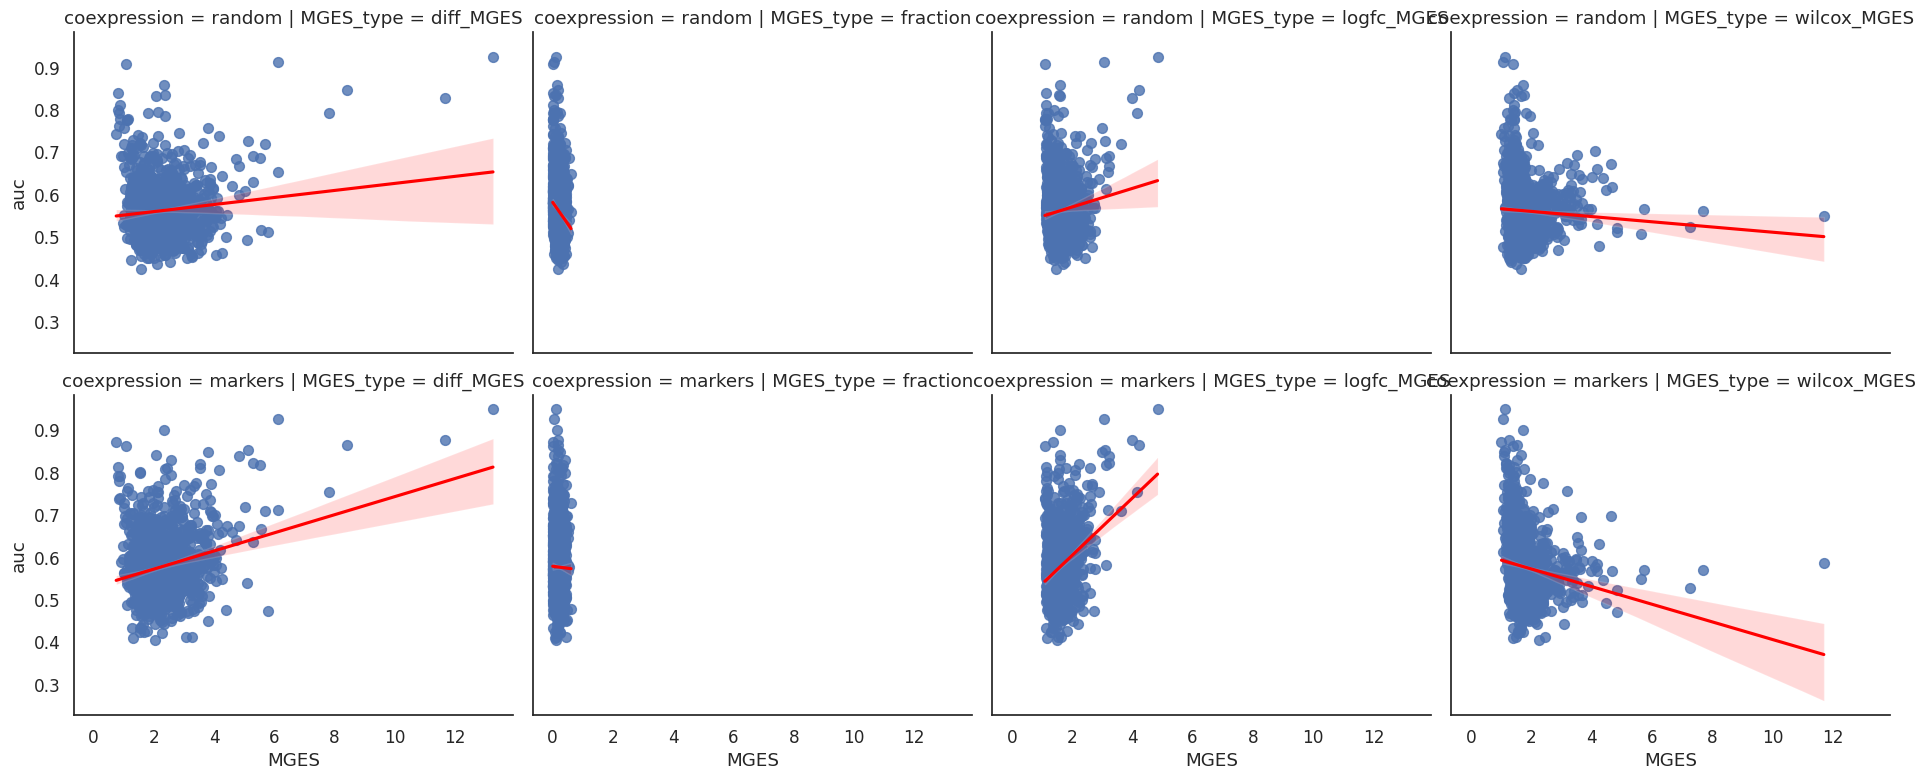

In [209]:

# Plot scatter plots with regression lines using lmplot
sns.lmplot(
    data=mean_values,         # Your DataFrame with mean values
    x='MGES', 
    y='auc', 
    row='coexpression', 
    col='MGES_type', 
    height=4,                 # Adjust the height of each facet
    aspect=1.2,               # Adjust the aspect ratio of each facet
    scatter_kws={'s': 50},    # Optional: Adjusts the size of scatter points
    line_kws={'color': 'red'} # Optional: Adjusts the color of the regression line
)


In [166]:
MGES_reg_melted

,index,meta,coexpression,auc,boot,MGES_type,MGES
0,GO:0000045,Neither,random,0.517223,0,wilcox_MGES,1.683795
1,GO:0000045,Neither,markers,0.555117,0,wilcox_MGES,1.683795
2,GO:0000045,Neither,markers,0.556386,1,wilcox_MGES,1.683795
3,GO:0000045,Neither,random,0.560044,1,wilcox_MGES,1.683795
4,GO:0000045,Neither,random,0.605602,2,wilcox_MGES,1.683795
...,...,...,...,...,...,...,...
692411,GO:2001244,Neither,random,0.555470,59,fraction,0.200000
692412,GO:2001244,Neither,random,0.604740,60,fraction,0.200000
692413,GO:2001244,Neither,markers,0.640873,60,fraction,0.200000
692414,GO:2001244,Neither,markers,0.640681,61,fraction,0.200000


In [162]:
# Check for missing values in 'auc' and 'MGES'
print(MGES_reg_melted[['auc', 'MGES']].isna().sum())


auc     0
MGES    0
dtype: int64


In [160]:
MGES_reg_melted

,index,meta,coexpression,auc,boot,MGES_type,MGES
0,GO:0000045,Neither,random,0.517223,0,wilcox_MGES,1.683795
1,GO:0000045,Neither,markers,0.555117,0,wilcox_MGES,1.683795
2,GO:0000045,Neither,markers,0.556386,1,wilcox_MGES,1.683795
3,GO:0000045,Neither,random,0.560044,1,wilcox_MGES,1.683795
4,GO:0000045,Neither,random,0.605602,2,wilcox_MGES,1.683795
...,...,...,...,...,...,...,...
692411,GO:2001244,Neither,random,0.555470,59,fraction,0.200000
692412,GO:2001244,Neither,random,0.604740,60,fraction,0.200000
692413,GO:2001244,Neither,markers,0.640873,60,fraction,0.200000
692414,GO:2001244,Neither,markers,0.640681,61,fraction,0.200000


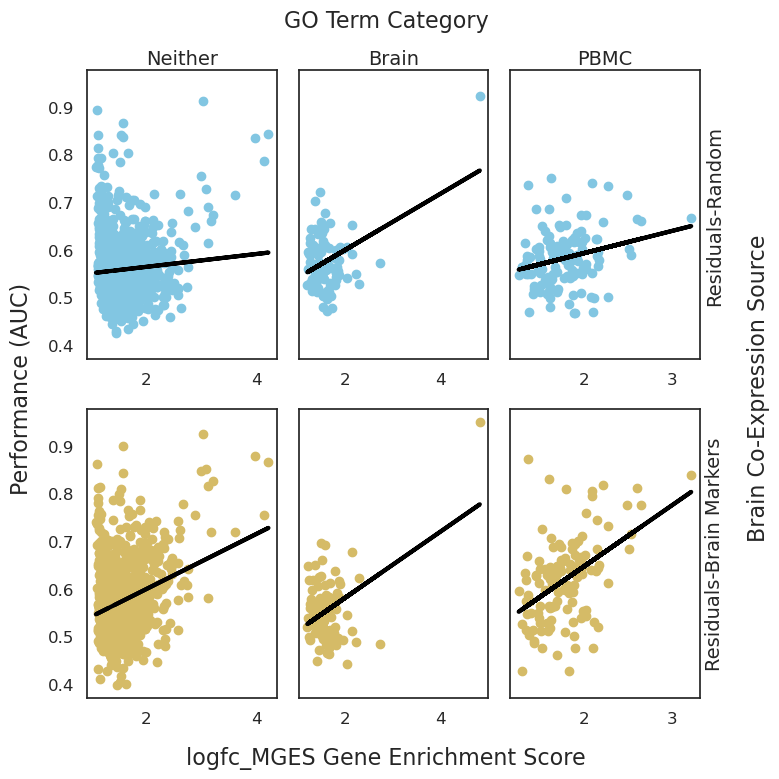

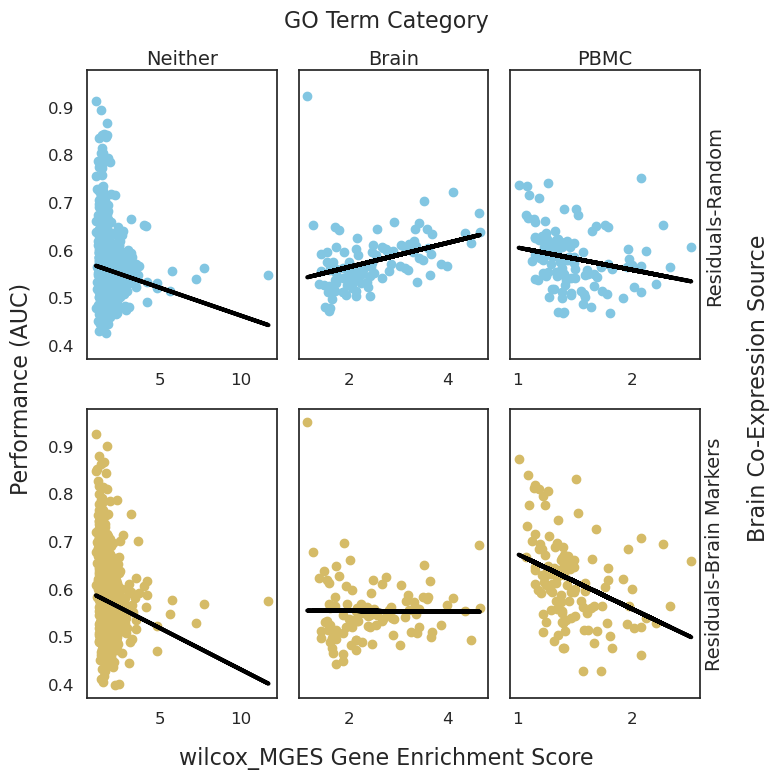

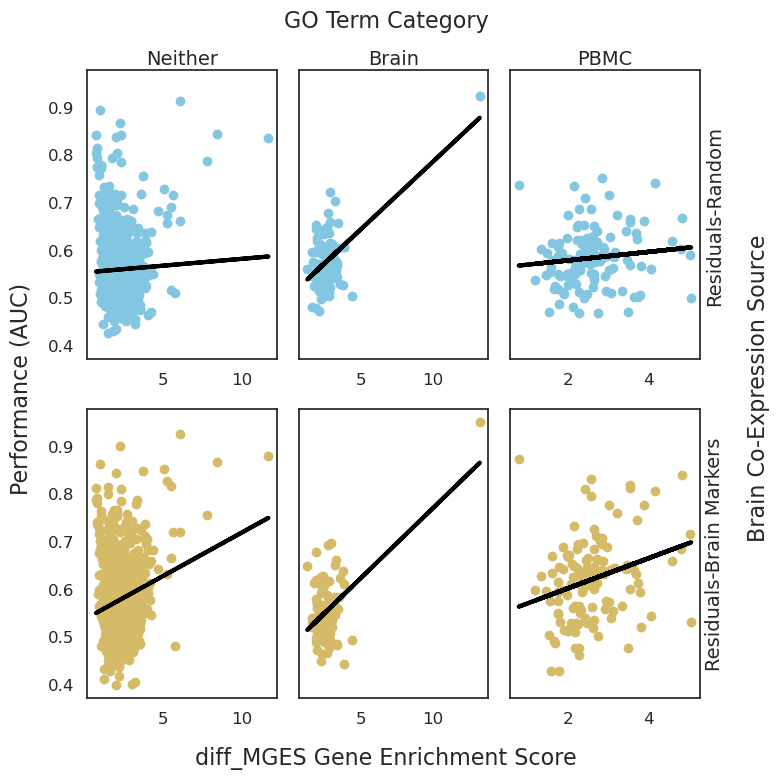

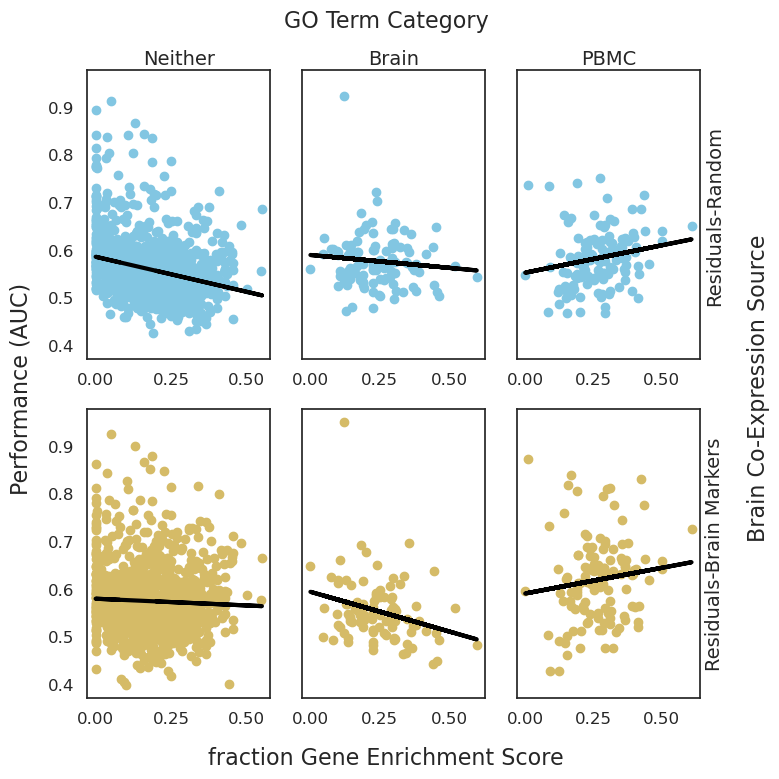

In [ ]:
def plot_reg_MGES(MGES_reg_model_df, MGES_type:str):
    # First. Filter for only MGES marker type
    MGES_reg_model_df = MGES_reg_model_df[MGES_reg_model_df.loc[:, 'MGES_type'] == MGES_type]

    # Define the orders for rows and columns
    col_order = ['Neither', 'Brain', 'PBMC']
    row_order = ['brain_rand', 'brain_markers']


    # Create a color palette
    palette = sns.color_palette('muted')[::-1]

    def plot_scatter_and_line(ax, subset, color, MGES_type):
        """Plot scatter and regression line on the given axes."""
        ax.scatter(x=subset['MGES'], y=subset['auc'], color=color)
        
        # Add a regression line
        m, b = np.polyfit(subset['MGES'], subset['auc'], 1)
        ax.plot(subset['MGES'], m * subset['MGES'] + b, color='black', linewidth=3)
        
        # Set axis labels to be empty
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Set tick label font sizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Remove titles
        ax.set_title('')

    # Create a grid of subplots
    fig, axes = plt.subplots(len(row_order), len(col_order), figsize=(8, 8), sharex=False, sharey=True,)

    # Loop through each combination of row and column
    for i, row_val in enumerate(row_order): # loop through GO categories
        color = palette[i] 
        for j, col_val in enumerate(col_order): # loop through GO categories loop through coexpression sources

            ax = axes[i, j] # Extract what axis we are on
            subset = MGES_reg_model_df[(MGES_reg_model_df['meta'] == col_val) & (MGES_reg_model_df['coexpression'] == row_val)] # subset data for specific values rn
            # Plot the data using the function
            plot_scatter_and_line(ax, subset, color, MGES_type=MGES_type)

    # Set labels for GO term categoriy
    axes[0, 2].set_ylabel('Residuals-Random', fontsize=14)
    axes[0, 2].yaxis.set_label_position('right')

    axes[1, 2].set_ylabel('Residuals-Brain Markers', fontsize=14)
    axes[1, 2].yaxis.set_label_position('right')


    # axes[2, 0].yaxis.labelpad = 25

    # Set labels for Coexpression Source

    axes[0, 0].set_xlabel('Neither', fontsize=14)
    axes[0, 0].xaxis.set_label_position('top')

    axes[0, 1].set_xlabel('Brain', fontsize=14)
    axes[0, 1].xaxis.set_label_position('top')

    axes[0, 2].set_xlabel('PBMC', fontsize=14)
    axes[0, 2].xaxis.set_label_position('top')

    # Set labels for Coexpression source and GO term category
    fig.text(0.5, 0.951, "GO Term Category", ha='center', fontsize=16)
    fig.text(0.951, 0.5, "Brain Co-Expression Source", va='center', rotation='vertical', fontsize=16)
    # Set label for MGES and Performance
    fig.text(0.5, 0.03, f"{MGES_type} Gene Enrichment Score", ha='center', fontsize=16)
    fig.text(0.03, 0.5, "Performance (AUC)", va='center', rotation='vertical', fontsize=16)

    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    plt.show()

    # Save the figure
    fig.savefig(f'final/MGES_AUC_corr_{MGES_type}.png', dpi=300)




plot_reg_MGES(MGES_reg_model_df=MGES_reg_melted, MGES_type='logfc_MGES')
plot_reg_MGES(MGES_reg_model_df=MGES_reg_melted, MGES_type='wilcox_MGES')
plot_reg_MGES(MGES_reg_model_df=MGES_reg_melted, MGES_type='diff_MGES')
plot_reg_MGES(MGES_reg_model_df=MGES_reg_melted, MGES_type='fraction')

